In [104]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import os
import re
from time import sleep
import pylab as pl
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.cbook import boxplot_stats
import math

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})  # increase plots resolution

##  Let's start by downloading our stock's screener from NASDAQ:

In [5]:
# STEP 1: Load stock screener data from nasdaq.
# The stock screener is a csv file downloaded from the nasdaq website and contains information (Symbol, market cap,
# sectors, industries and more) about different stocks.



chromeOptions = webdriver.ChromeOptions()
cur_dir = os.getcwd()
prefs = {"download.default_directory" : cur_dir}
chromeOptions.add_experimental_option("prefs",prefs)

driver = webdriver.Chrome(executable_path=ChromeDriverManager().install(), chrome_options=chromeOptions)
driver.get("https://www.nasdaq.com/market-activity/stocks/screener")

driver.implicitly_wait(5)
link = driver.find_element_by_class_name("nasdaq-screener__download")
link.click()


file_location = os.path.join(cur_dir, 'nasdaq_screener.csv')

if os.path.isfile(file_location):
    os.remove(file_location) # delete if previous file exists

# delete suffix from the csv file's name
file_regex = re.compile('nasdaq_screener_\d+\.csv')

sleep(15)

while not os.path.isfile(file_location):
    for root, dirs, files in os.walk(cur_dir):
        for f in files:
            if file_regex.match(f):
                os.rename(f, 'nasdaq_screener.csv')
                break


driver.close()



====== WebDriver manager ======
Current google-chrome version is 98.0.4758
Get LATEST chromedriver version for 98.0.4758 google-chrome
Driver [/Users/nadavsmacbookpro/.wdm/drivers/chromedriver/mac64/98.0.4758.102/chromedriver] found in cache
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  app.launch_new_instance()


## Load the downloaded data into a panda dataframe:

### (*) In order to avoid new stocks with a small documented history, we will only take stocks that opened to the market before 2021.

### (*) Stocks with 'Empty' sector will be marked as 'undefined' for future use.

In [36]:
# Get tickers from csv to pandas

stocks_screener = pd.read_csv('nasdaq_screener.csv')
stocks_screener = stocks_screener.sort_values(by='Market Cap', ascending=False)
stocks_screener["IPO Year"].fillna(2022, inplace=True)
stocks_screener = stocks_screener.drop(stocks_screener[stocks_screener["IPO Year"] >= 2021].index)

stocks_screener["Sector"].fillna('undefined', inplace=True)
stocks_screener["Industry"].fillna('undefined', inplace=True)

# show the head of the screener:
stocks_screener.head()

Symbol                                 Name Last Sale  Net Change  \
19     AAPL              Apple Inc. Common Stock   $164.85        2.11   
5126   MSFT   Microsoft Corporation Common Stock   $297.31        2.72   
3437   GOOG  Alphabet Inc. Class C Capital Stock  $2690.39       36.92   
3438  GOOGL   Alphabet Inc. Class A Common Stock  $2689.19       35.37   
477    AMZN         Amazon.com Inc. Common Stock  $3075.77       48.61   

     % Change    Market Cap        Country  IPO Year    Volume  \
19     1.297%  2.858060e+12  United States    1980.0  91878387   
5126   0.923%  2.228893e+12  United States    1986.0  32528003   
3437   1.391%  1.778271e+12  United States    2004.0   1311053   
3438   1.333%  1.777477e+12  United States       NaN   1818031   
477    1.606%  1.565088e+12  United States    1997.0   3116733   

                 Sector                                 Industry  
19           Technology                   Computer Manufacturing  
5126         Technology  Computer Software: Prepackaged Software  
3437         Technology        Internet and Information Services  
3438         Technology        Internet and Information Services  
477   Consumer Services           Catalog/Specialty Distribution

## In order the reduce the complexity of the problem we will limit the number of stocks from each sector:

In [37]:
# Load N_STOCKS from each sector
N_STOCKS = 50

sectors_set = set(stocks_screener["Sector"])
sectors_dict = {sector: list(stocks_screener.loc[stocks_screener["Sector"] == sector]["Symbol"][:N_STOCKS])
                for sector in sectors_set}
sectors_dict.pop('undefined') # remove undefined data

## After filtering our stocks by sector, we will download the time series values of each stock:
* Measure time last year from now until five days from now. [1y <= t <= Today - 5d].
* Skip stocks that don't have more than 200 days of documentation.
* Only take days that intersect with every stock in our filtered data.

In [40]:
# pull price using iex for each symbol in list defined above
start = datetime.today() + relativedelta(months=-12)
end = datetime.today() + relativedelta(days=-5)
stocks_time_series = []
dates = set()
for key, value in sectors_dict.items():
    print(f"######### {key} #########\n")
    for ticker in value:
        try :
            r = web.DataReader(ticker, 'yahoo', start, end)
        except:
            continue
        if len(r.index) < 200:
            continue

        if len(dates) == 0:
            dates = set(r.index)
        else:
            dates = dates.intersection(set(r.index))

        # add a symbol column
        r['Symbol'] = ticker
        r['Industry'] = list(stocks_screener.loc[stocks_screener["Symbol"] == ticker]['Industry'])[0]

        stocks_time_series.append(r)
stocks_time_series = pd.concat(stocks_time_series)
stocks_time_series.to_csv('time_series_stocks_backup.csv')
stocks_time_series = pd.read_csv('time_series_stocks_backup.csv')

######### Finance #########

######### Public Utilities #########

######### Basic Industries #########

######### undefined #########

######### Consumer Durables #########

######### Miscellaneous #########

######### Energy #########

######### Health Care #########

######### Transportation #########

######### Consumer Non-Durables #########

######### Technology #########

######### Capital Goods #########

######### Consumer Services #########



### Load the saved data in case of a failure (to save downloading time ).

In [66]:
stocks_time_series = pd.read_csv('time_series_stocks_backup.csv')


### Some helper funcs:

In [159]:
def unify_data(dataframe):
    df = dataframe.sort_values(by='Industry')
    df = df.reset_index()
    df = df[['Date', 'Close', 'Symbol']]
    return df.pivot(index='Date', columns='Symbol', values='Close').sort_index()

def calc_profit(dataframe, is_method_one=False):
    df = dataframe
    if not is_method_one:
        df = unify_data(dataframe).loc[[str(date).split(' ')[0] for date in dates]].sort_index()
    return (df.iloc[-1] * 100) / data.iloc[0]

def plot_profit(dataframe, y_upper, y_bottom, cluster_num):
    sns.barplot(x='Stock Symbol', y='Profit', data=dataframe[-10:])
    plt.xticks(rotation=45)
    plt.ylim(y_bottom, y_upper)
    plt.title(f"10 most profitable stocks from the \"{cluster_num}\" cluster")
    plt.xlabel("Stock Symbol")
    plt.ylabel("Profit")
    plt.show()

def print_results(results, results_score, num_of_clusters):
    print("We recommend to invest in:")
    for i in range(num_of_clusters):
        stock_symbol = results[i]
        print(stock_symbol)
        stock_sector = stocks_screener.loc[stocks_screener["Symbol"] == stock_symbol]["Sector"].values[0]
        print(f'\'{stock_symbol}\' stock from the {stock_sector} sector, with score of {np.round(results_score[i], 3)}, from the \"{i}\" cluster')

def most_frequent(List):
    return max(set(List), key = List.count)

# Method 1 - 2D clustering:
* Skip this part if you want to run the DTW implementation.


* Let's start by creating our data:

In [86]:
data = unify_data(stocks_time_series).loc[[str(date).split(' ')[0] for date in dates]].sort_index()  # only take common dates
data_change = data.pct_change()
returns = data_change.mean() * N_STOCKS
variance = data_change.std() * np.sqrt(N_STOCKS)
returns.columns = ["Returns"]
variance.columns = ["Variance"]
#Concatenating the returns and variances into a single data-frame
ret_var = pd.concat([returns, variance], axis = 1).dropna()
ret_var.columns = ["Returns","Variance"]

### Use the elbow method in order to estimate K:

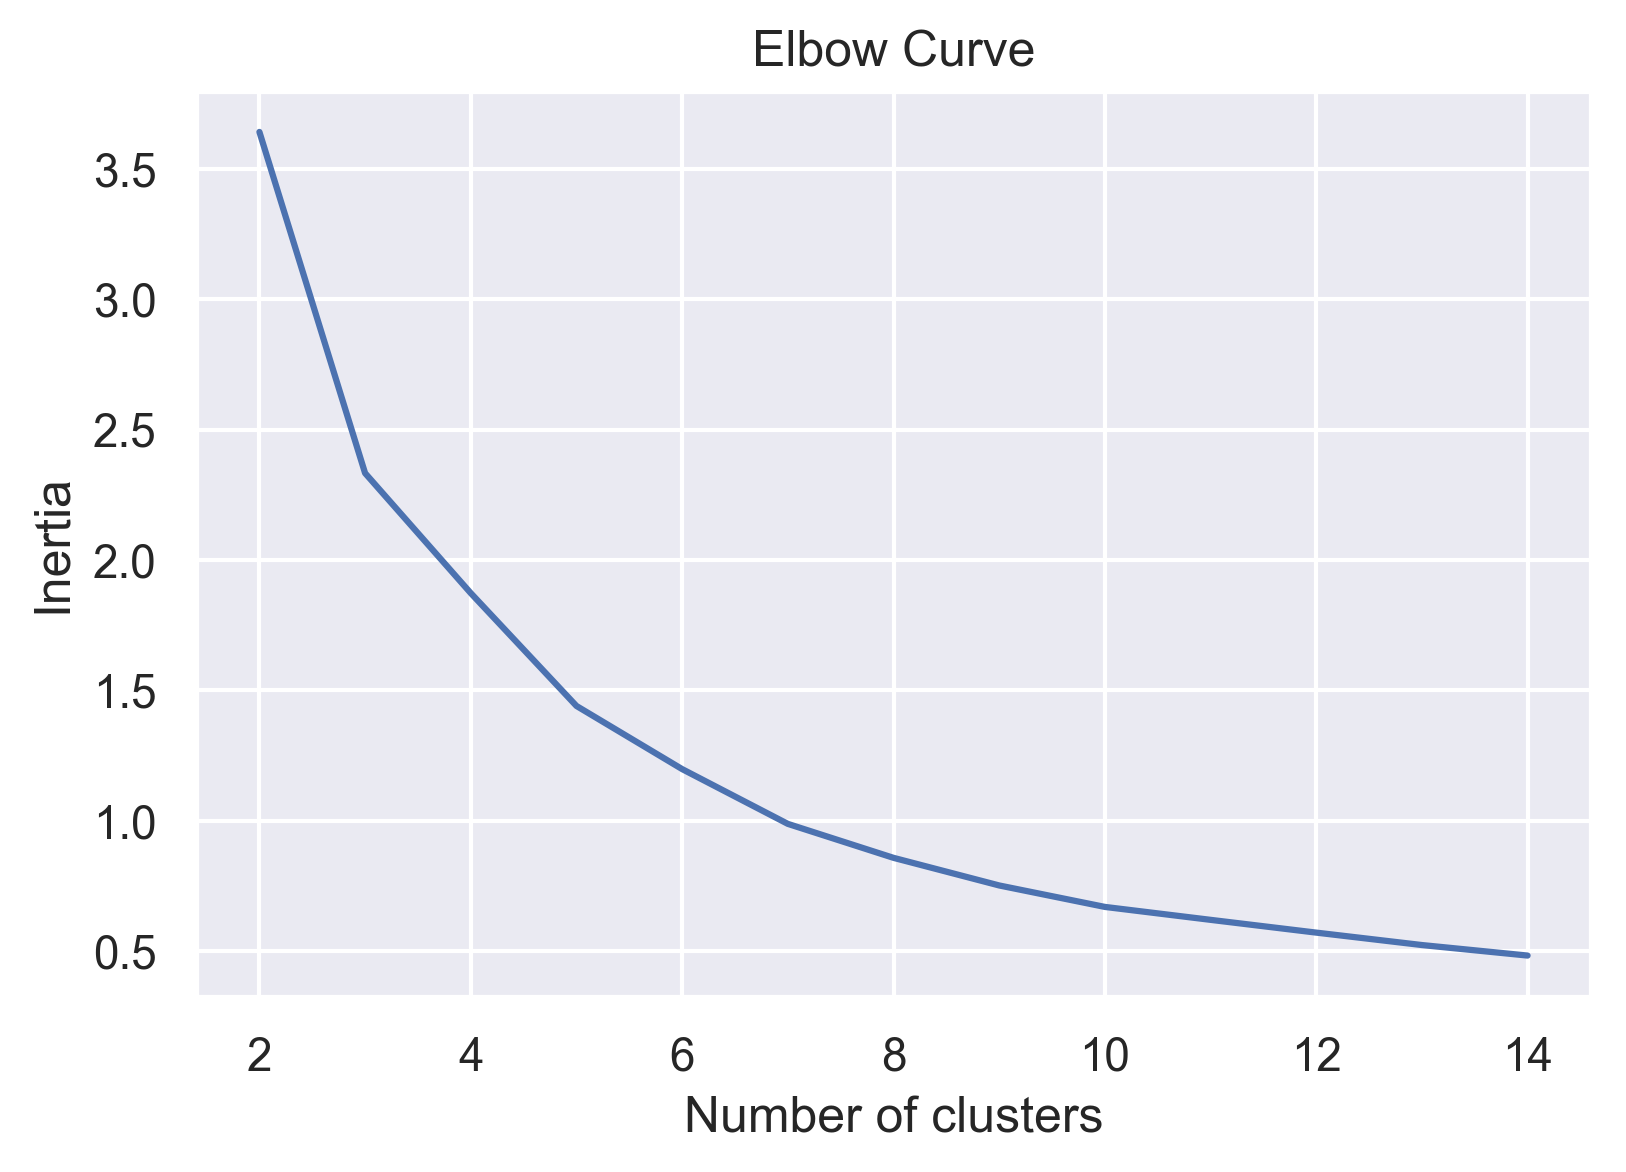

In [87]:
X =  ret_var.values #Converting ret_var into nummpy array
sse = []
for k in range(2,15):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_) #SSE for each n_clusters
pl.plot(range(2,15), sse)
pl.title("Elbow Curve")
pl.xlabel("Number of clusters")
pl.ylabel("Inertia")
pl.show()


* Choose 'K' according to the elbow method:

In [88]:
K = 4


### Clean outliers:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, n

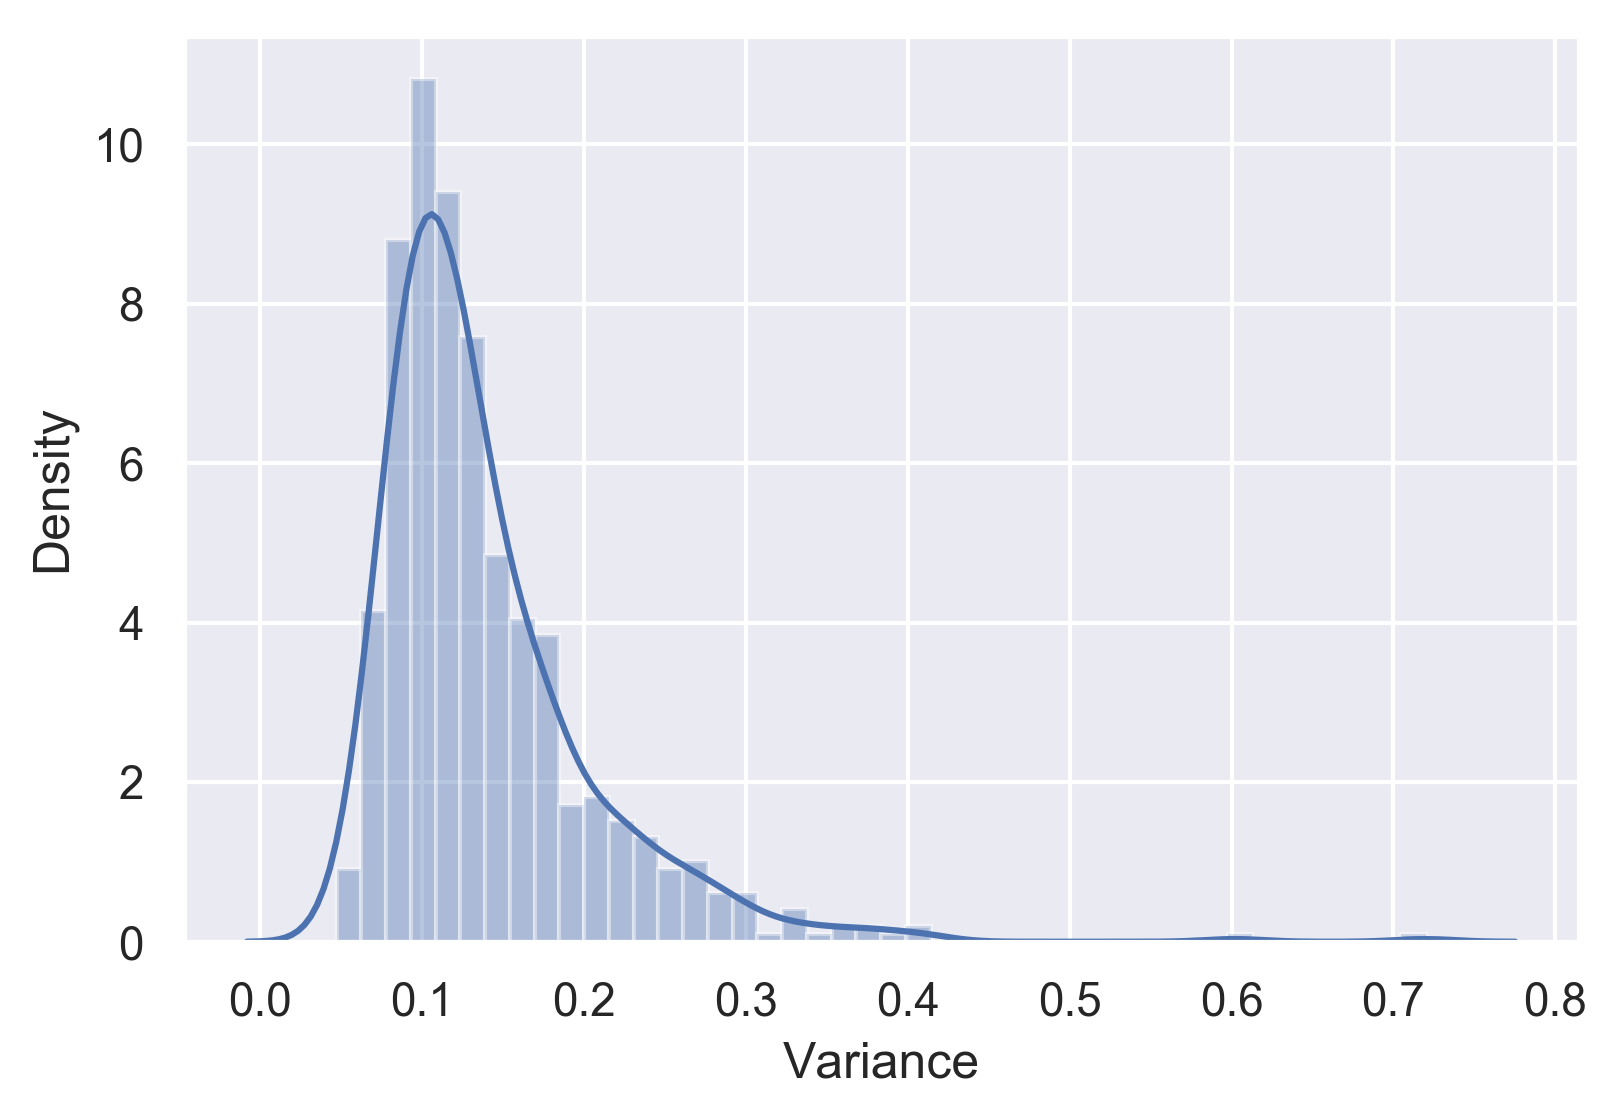

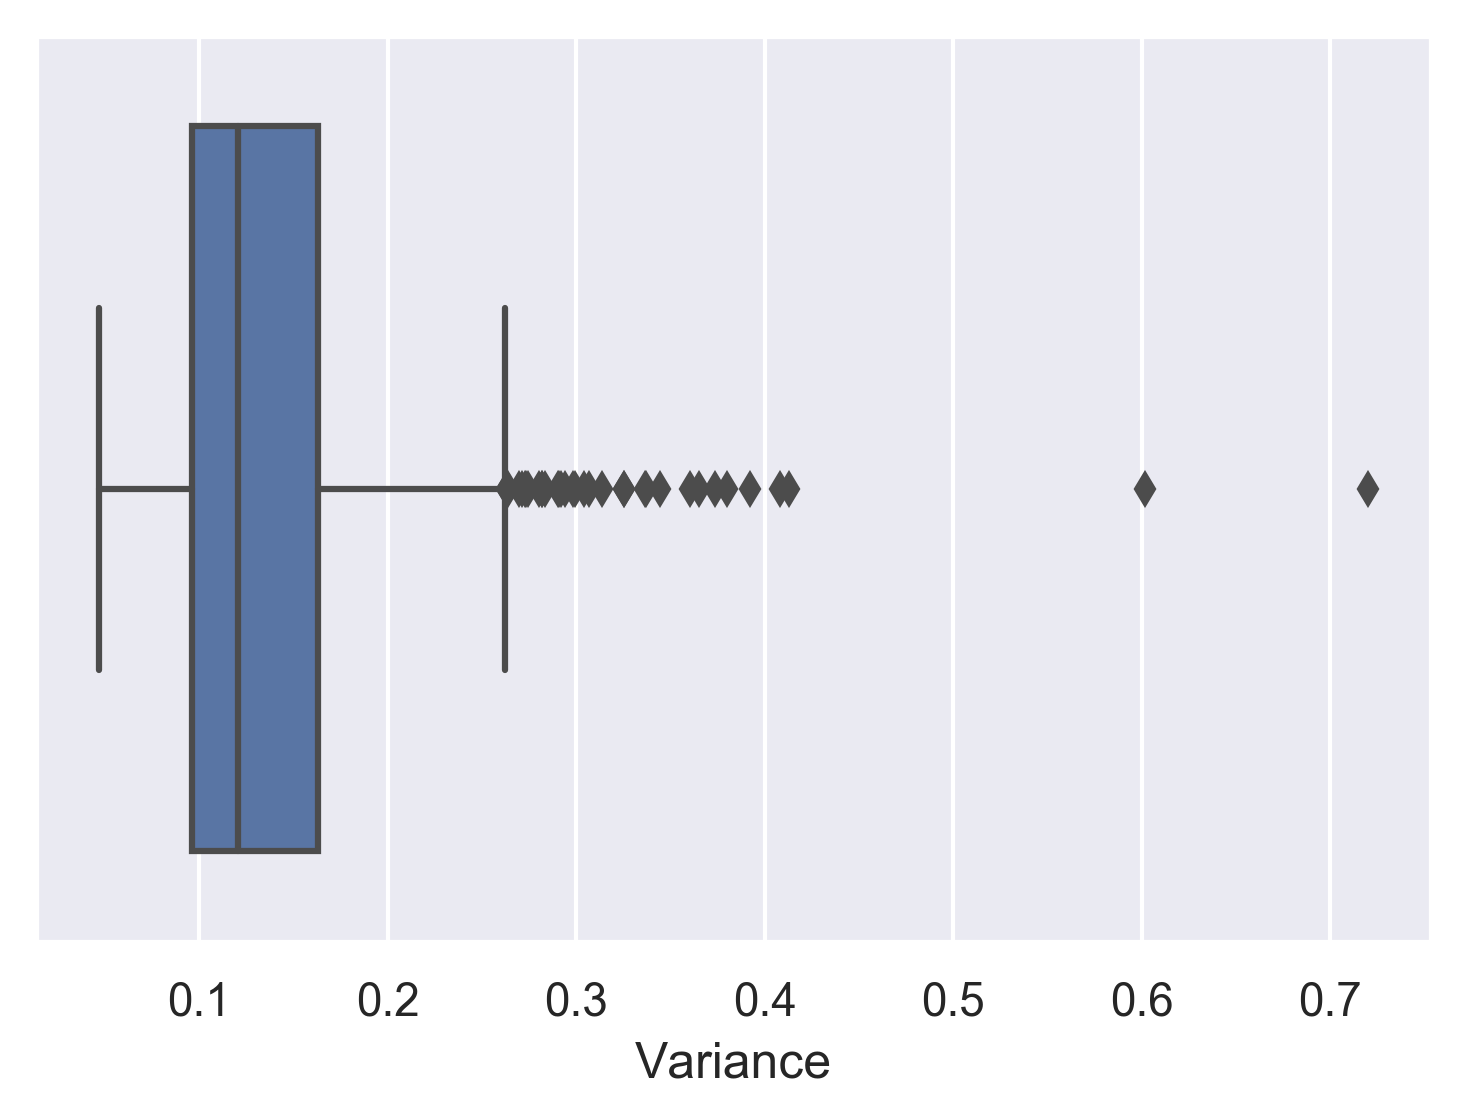

In [89]:
# todo - try to extracy the boundaries of the boxPlot
sns.distplot(ret_var["Variance"])
plt.show()
sns.boxplot(ret_var["Variance"])
plt.show()

upper_limit = ret_var['Variance'].quantile(0.99)
lower_limit = ret_var['Variance'].quantile(0.01)

boxplot_bounds = boxplot_stats(ret_var['Variance']).pop(0)
left_bound = boxplot_bounds['whislo']
right_bound = boxplot_bounds['whishi']

ret_var = ret_var[(ret_var['Variance'] <= right_bound) & (ret_var['Variance'] >= left_bound)]
data = data[data.columns.intersection(ret_var.index.tolist())]

### Plot the result graph with clusters result:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


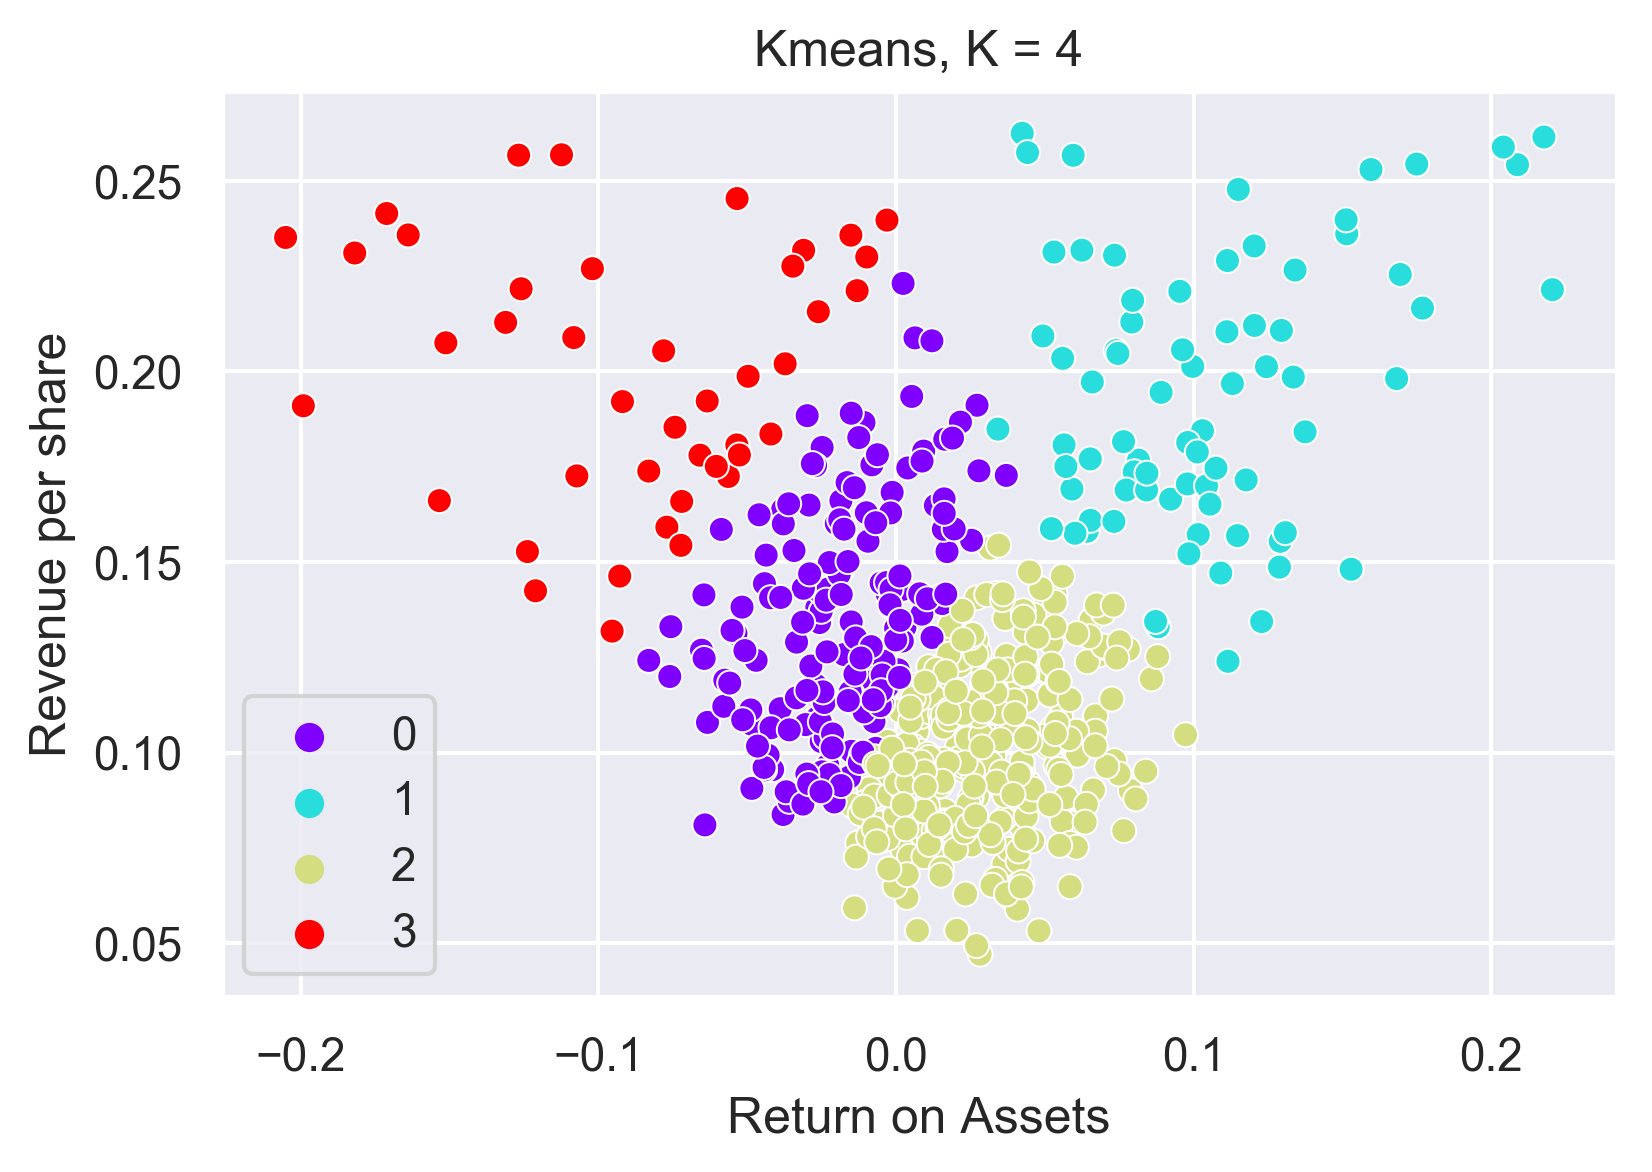

In [90]:
X =  ret_var.values #Converting ret_var into nummpy array

kmeans = KMeans(n_clusters=K).fit(X)
centroids = kmeans.cluster_centers_
# kmeans = X.to_numpy()

sns.scatterplot(X[:, 0], X[:, 1], hue=kmeans.labels_, palette='rainbow')
plt.title(f"Kmeans, K = {K}")
plt.xlabel("Return on Assets")
plt.ylabel("Revenue per share")
pl.show()

### Plot the profit graph:

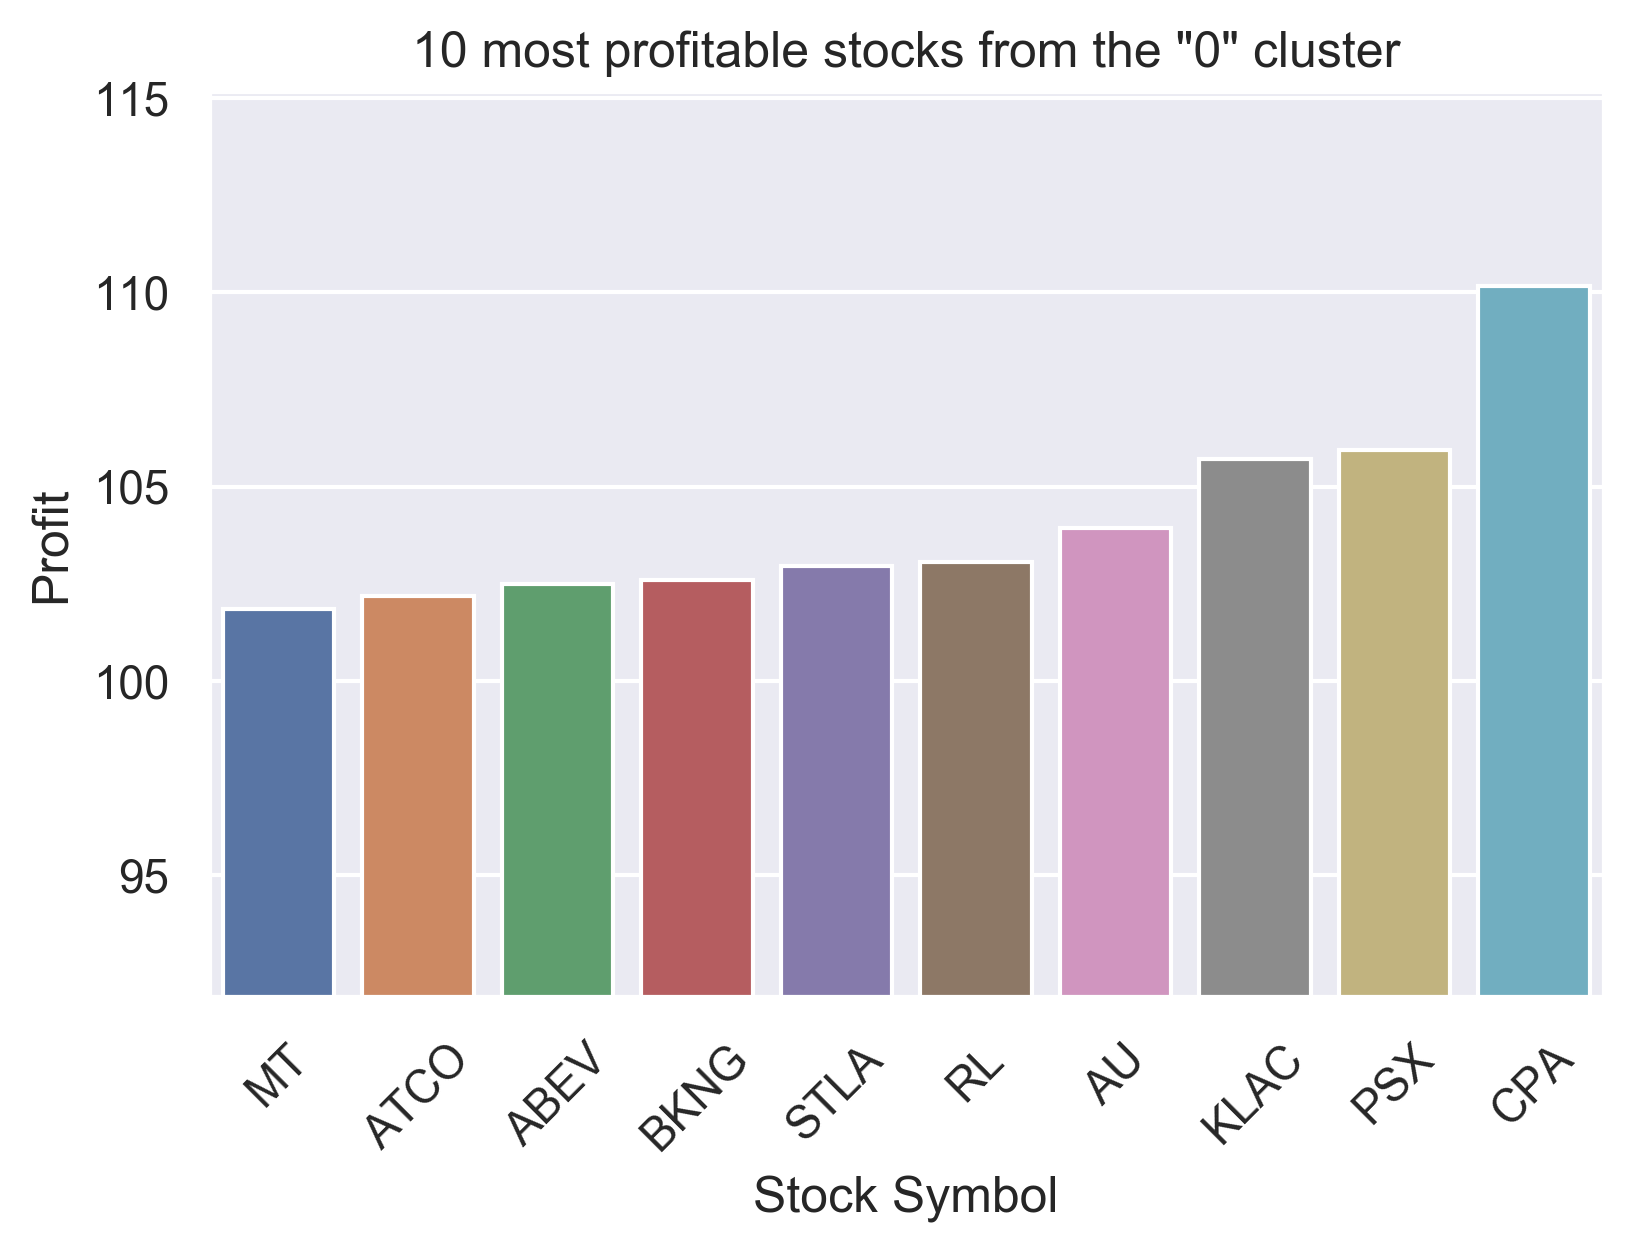

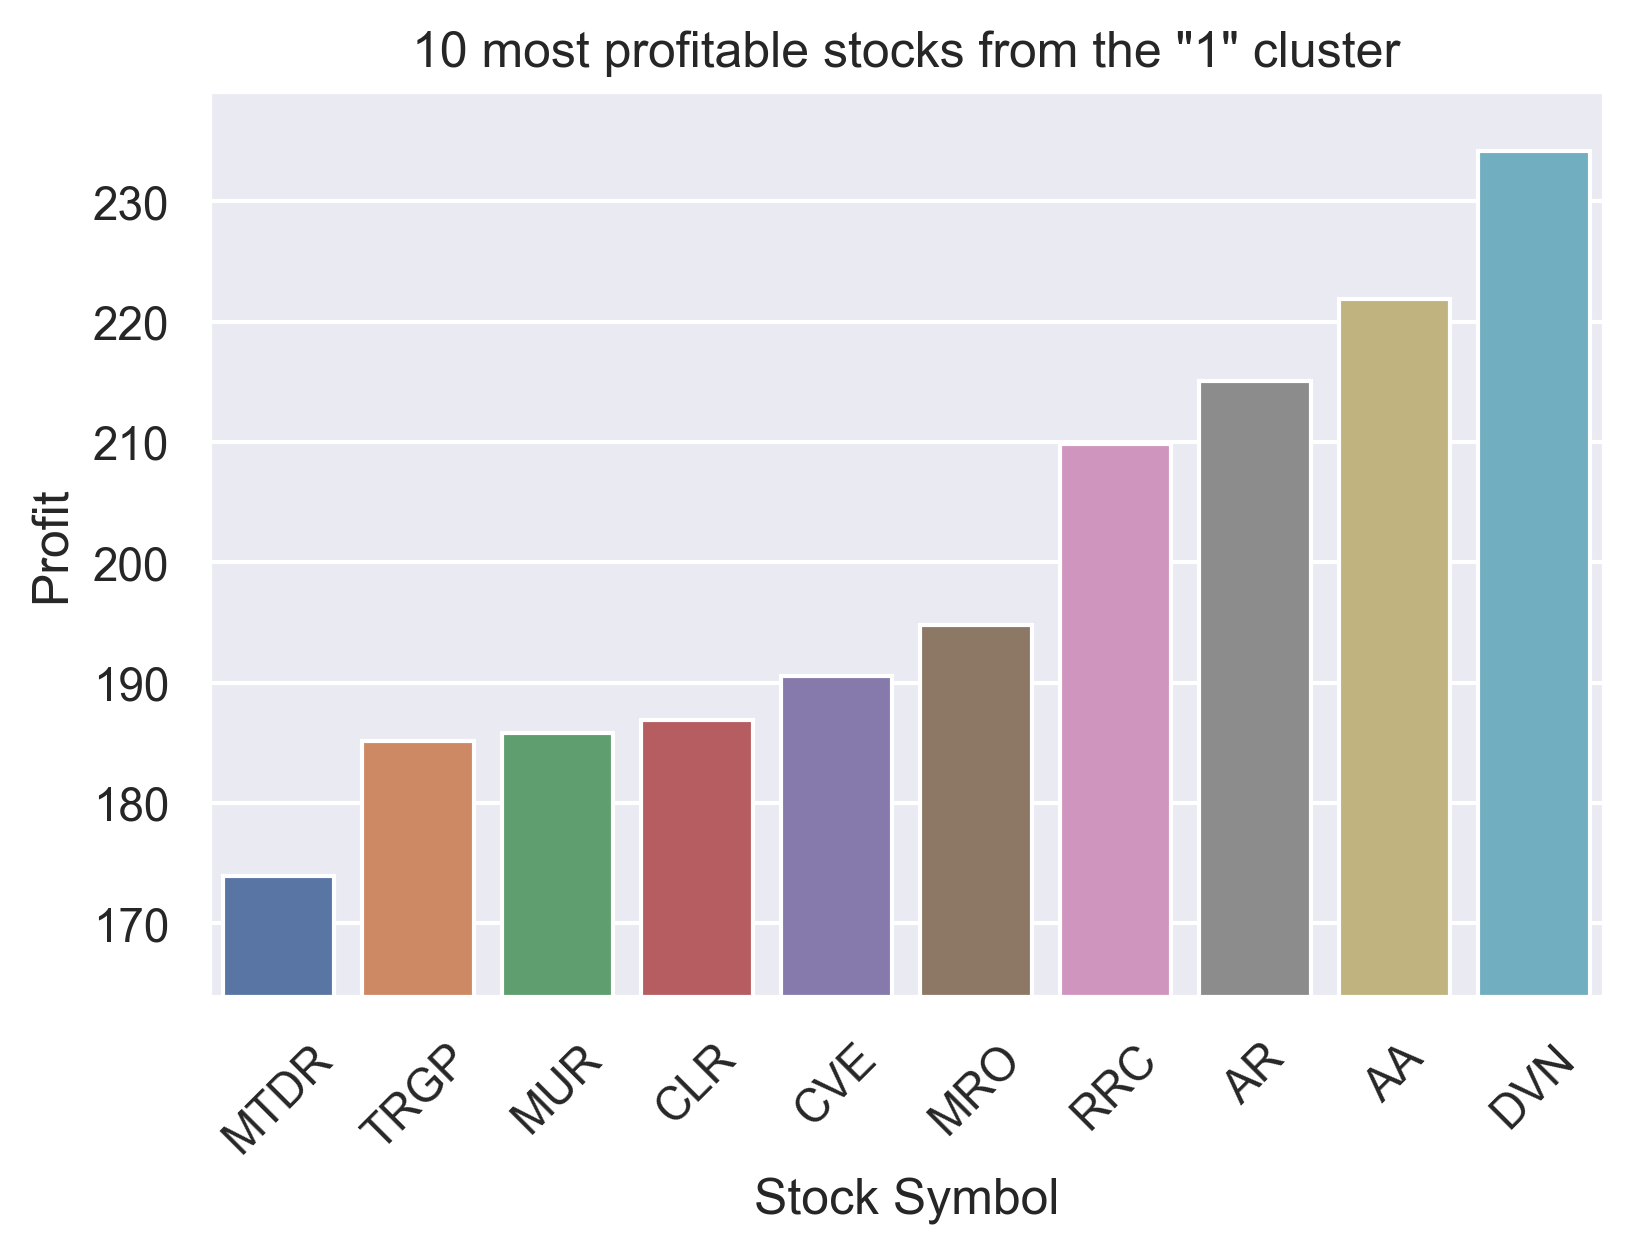

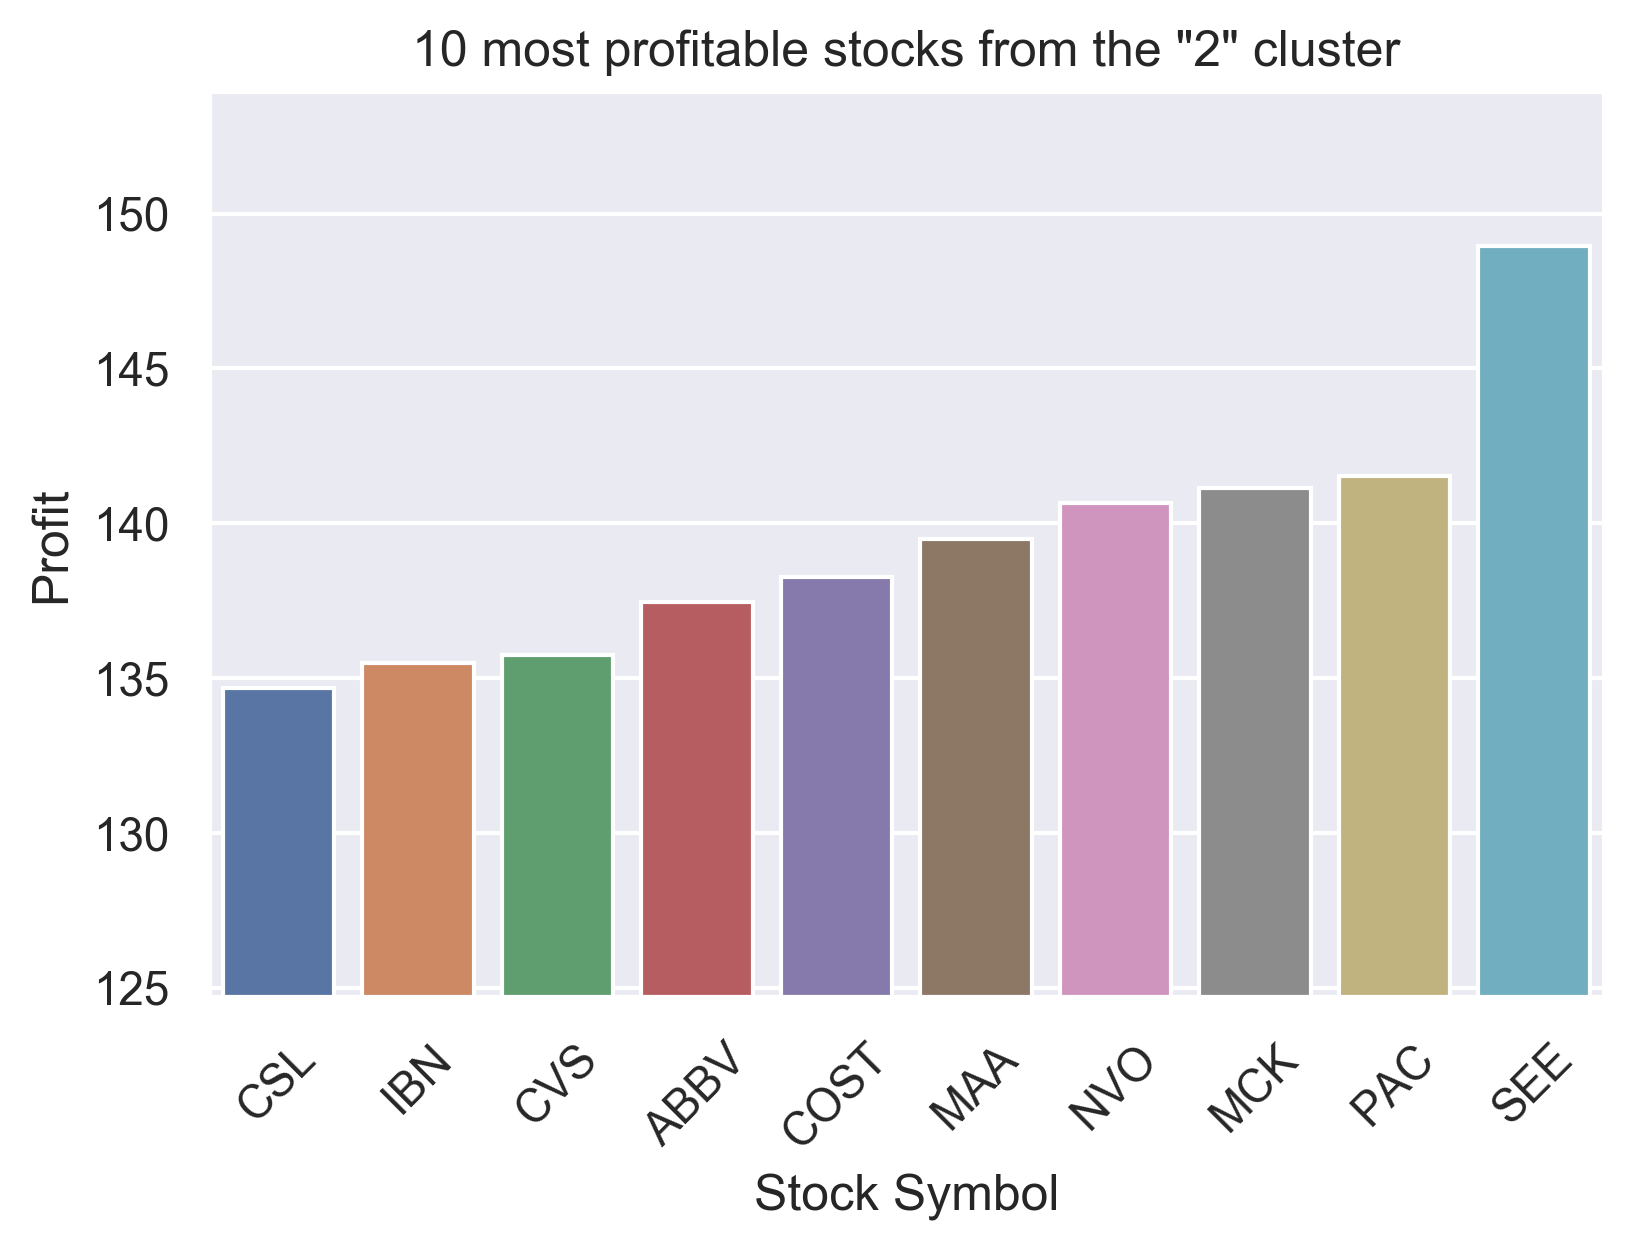

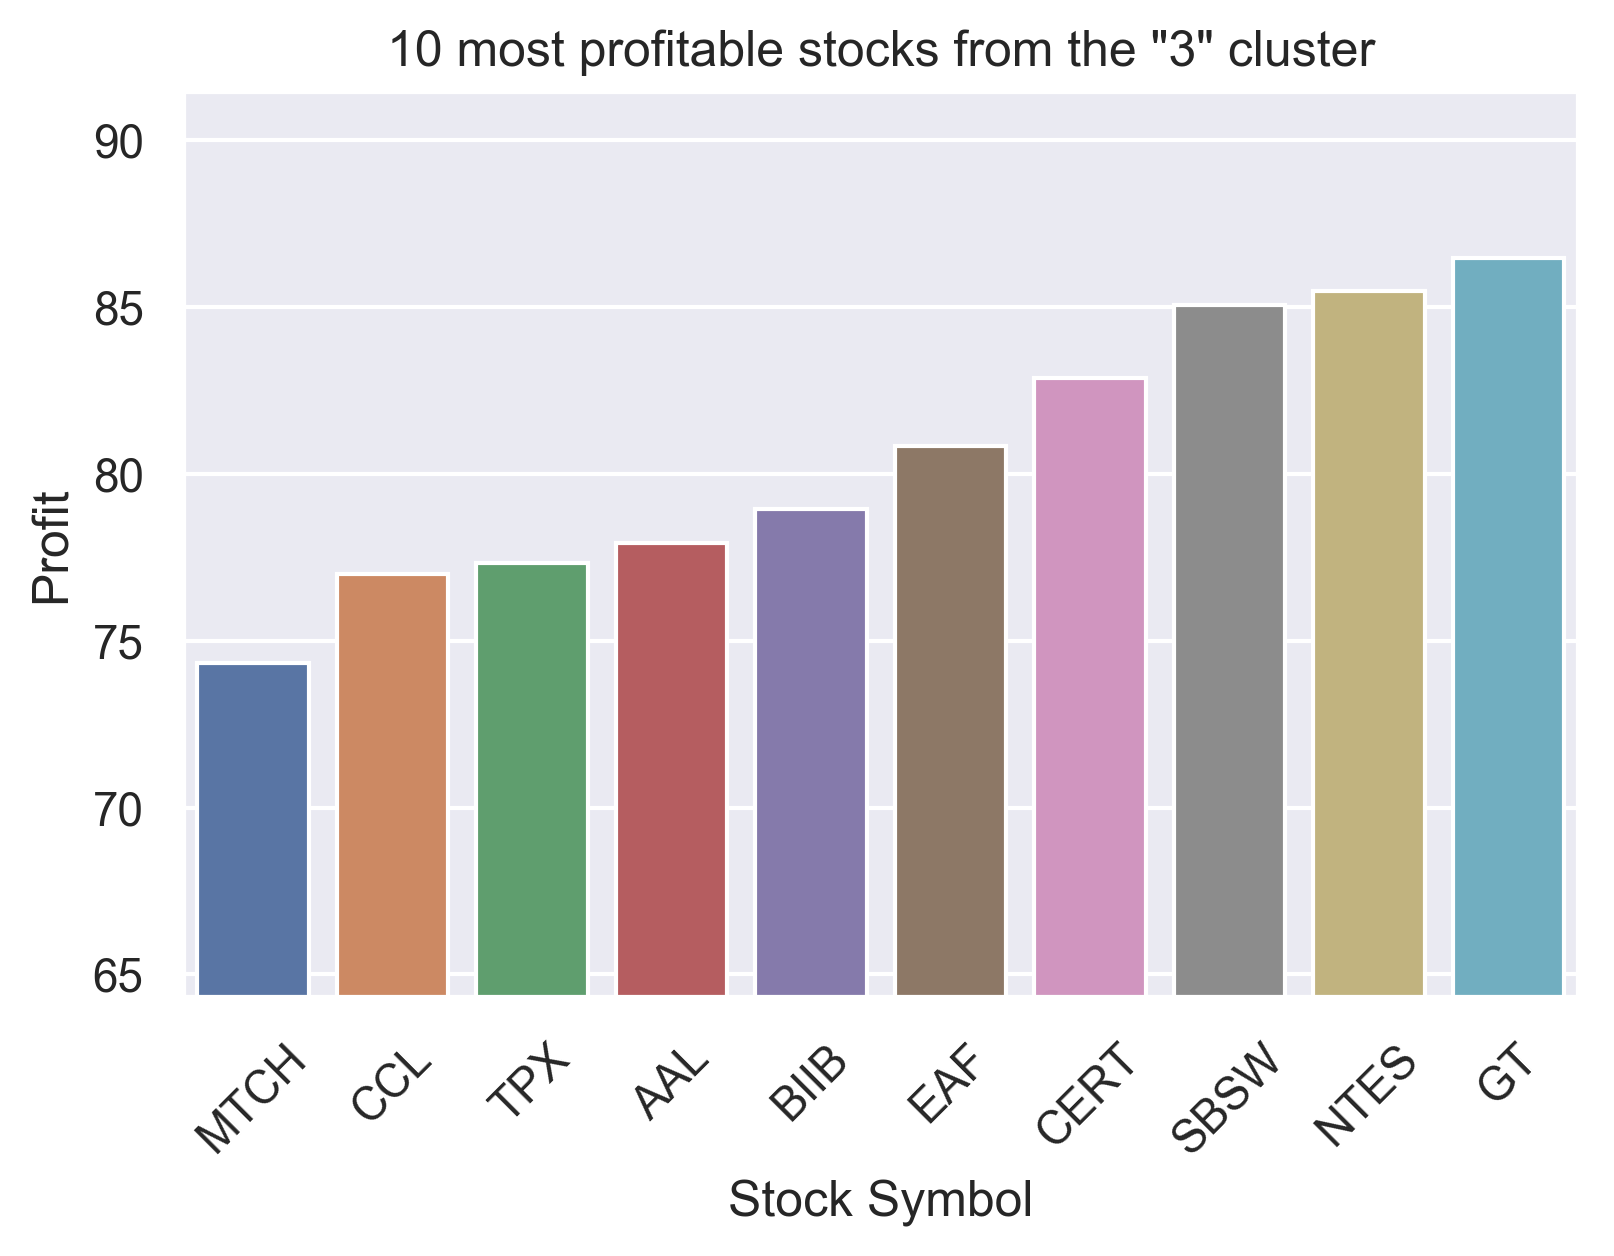

In [142]:
# dist from centroid:
x_dist = kmeans.transform(X) ** 2
x_dist = x_dist.sum(axis=1)

profit = calc_profit(data, True)
tickers = data.columns
values = profit.values

results, results_score = [], []
for i in range(K):
    indexes = kmeans.labels_ == i
    t = tickers[indexes]
    v = values[indexes]
    centroid_dists = - x_dist[indexes] / np.sum(x_dist[indexes])
    df = pd.DataFrame({'Profit': v, "Stock Symbol": t, "centroid dist": centroid_dists}).sort_values(by='Profit')

    plot_profit(df, max(df["Profit"][-10:]) + 5, max(0, min(df["Profit"][-10:])-10), i)

    df["Profit"] /= np.sum(v)
    max_results = []
    max_results_score = []
    for j, p in enumerate(np.linspace(0.0, 1.0, 10)):
        tmp = ((df["Profit"] * p) + (df["centroid dist"] * (1 - p))).tolist()
        df[f'{j}'] = tmp
        max_results.append(df.loc[df[f'{j}'].idxmax()]["Stock Symbol"])
        max_results_score.append(df.loc[df[f'{j}'].idxmax()][f'{j}'])
    results.append(most_frequent(max_results))
    results_score.append(max_results_score[max_results.index(results[-1])])

### Print results:

In [143]:
print_results(results, results_score, K)

We recommend to invest in:
CPA
'CPA' stock from the Transportation sector, with score of 0.003, from the "0" cluster
VLO
'VLO' stock from the Energy sector, with score of -0.0, from the "1" cluster
PAA
'PAA' stock from the Energy sector, with score of -0.001, from the "2" cluster
TPX
'TPX' stock from the Consumer Durables sector, with score of -0.011, from the "3" cluster


# Method 2 - DTW clustering:


* Choose the number of clusters:

In [105]:
cluster_count = 6

In [108]:
df_union = unify_data(stocks_time_series)
mySeries = df_union.to_numpy().T

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

### Plot time series clustered graphs

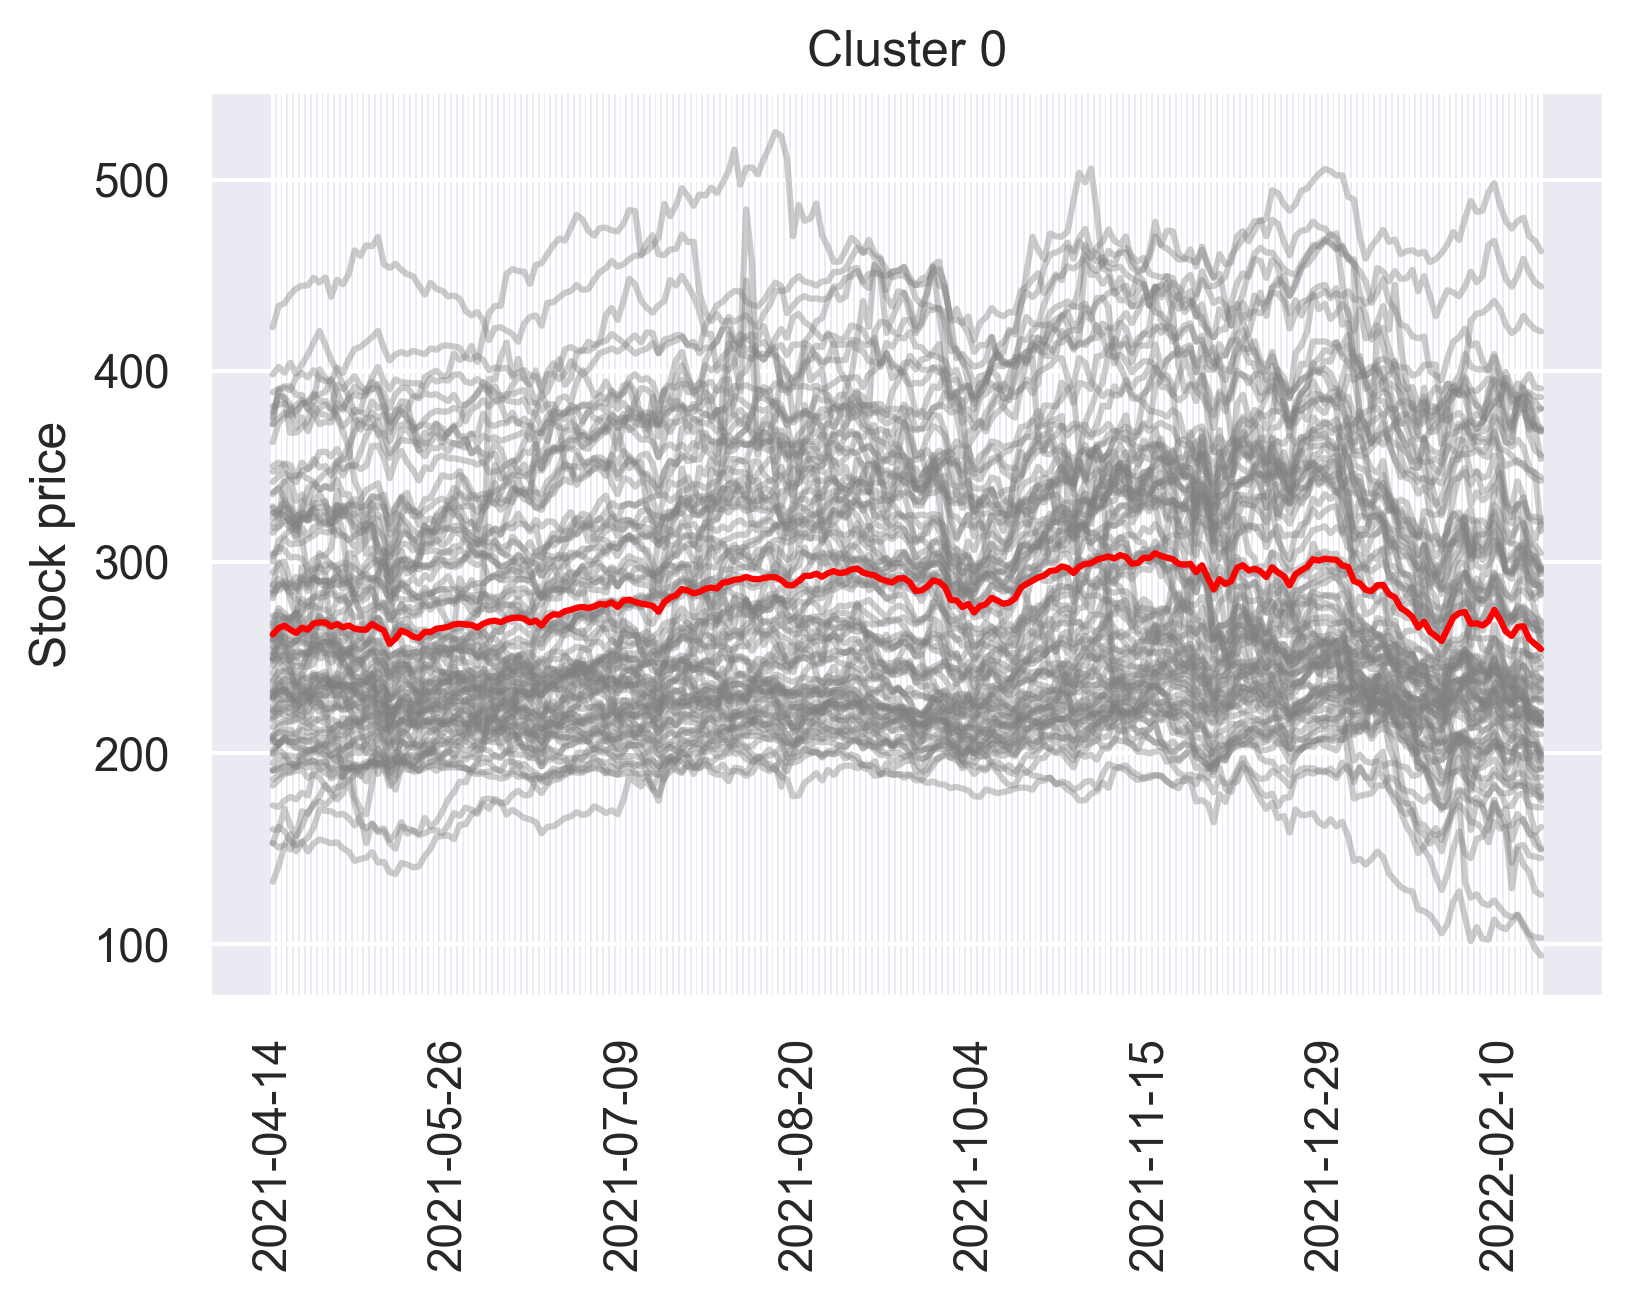

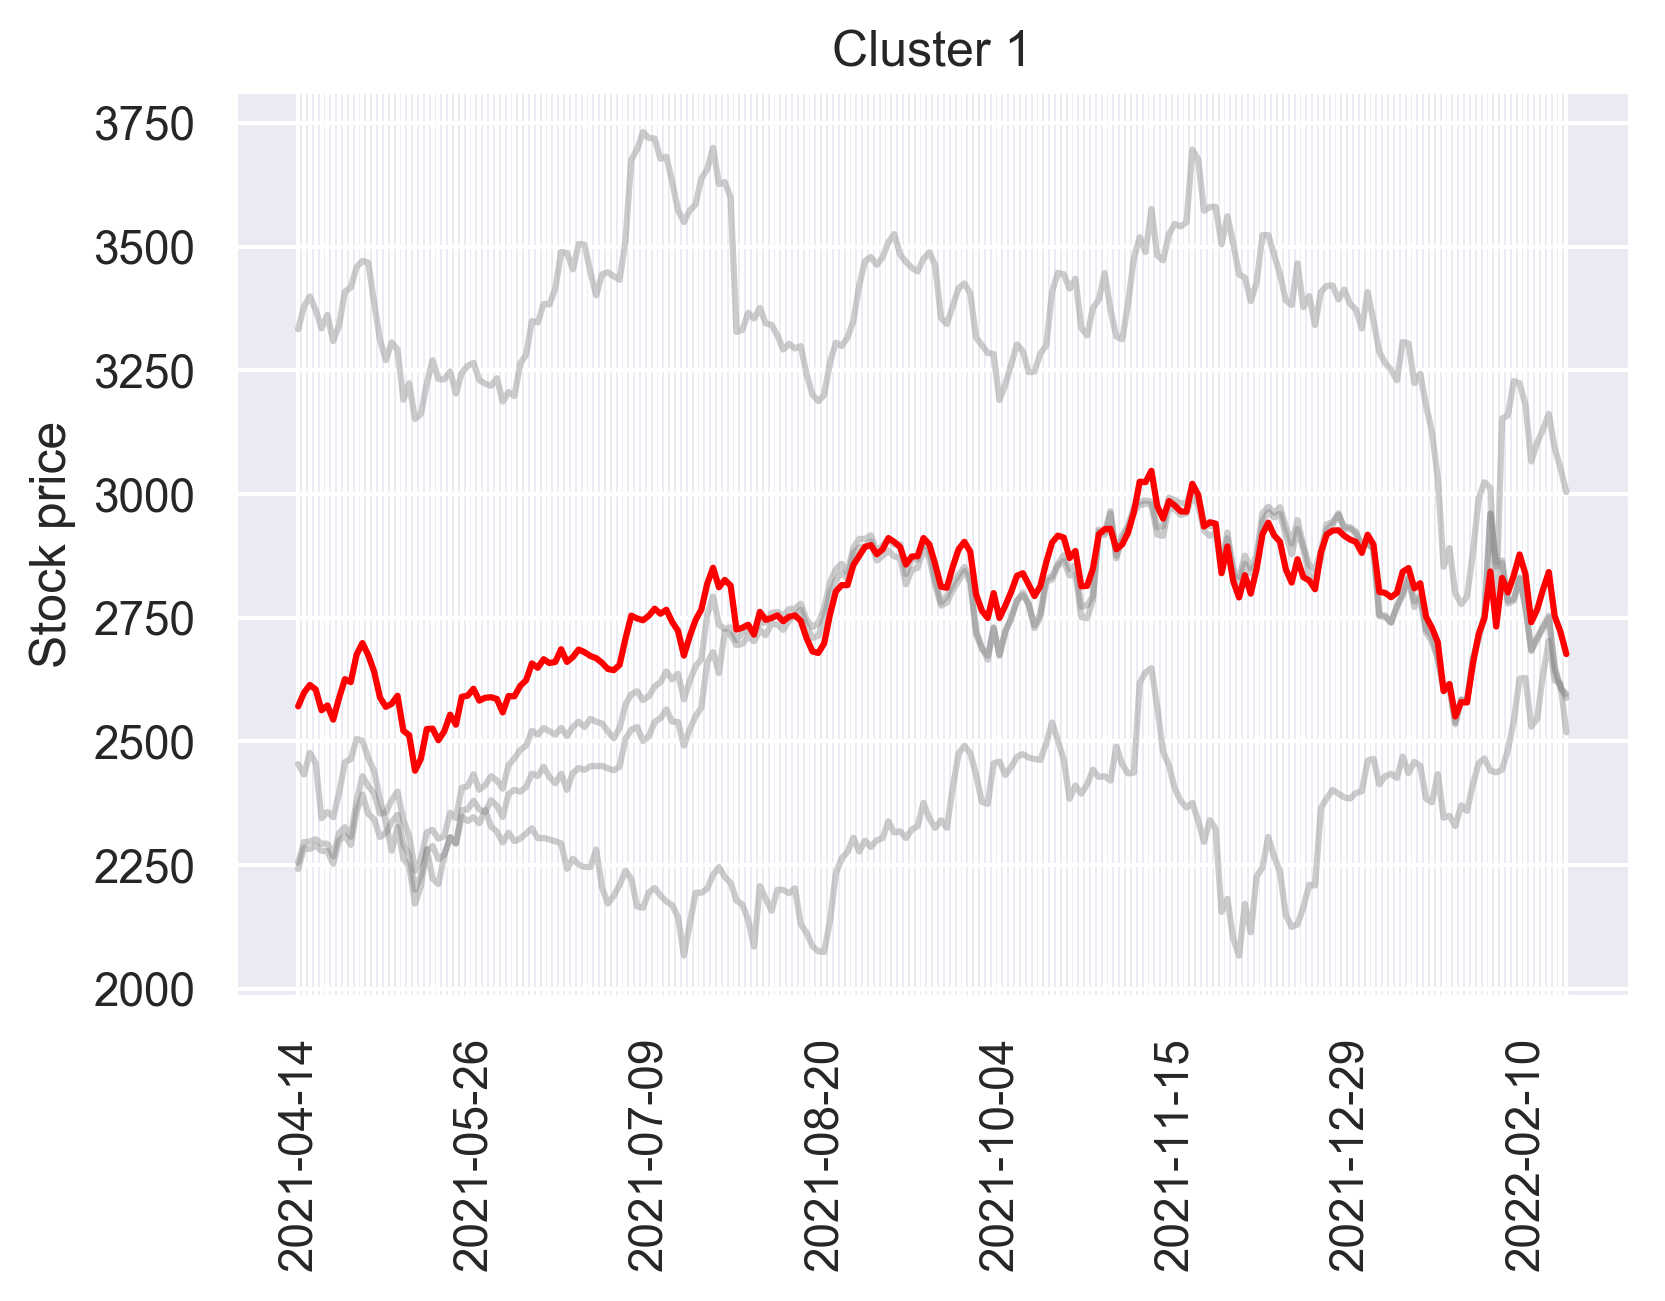

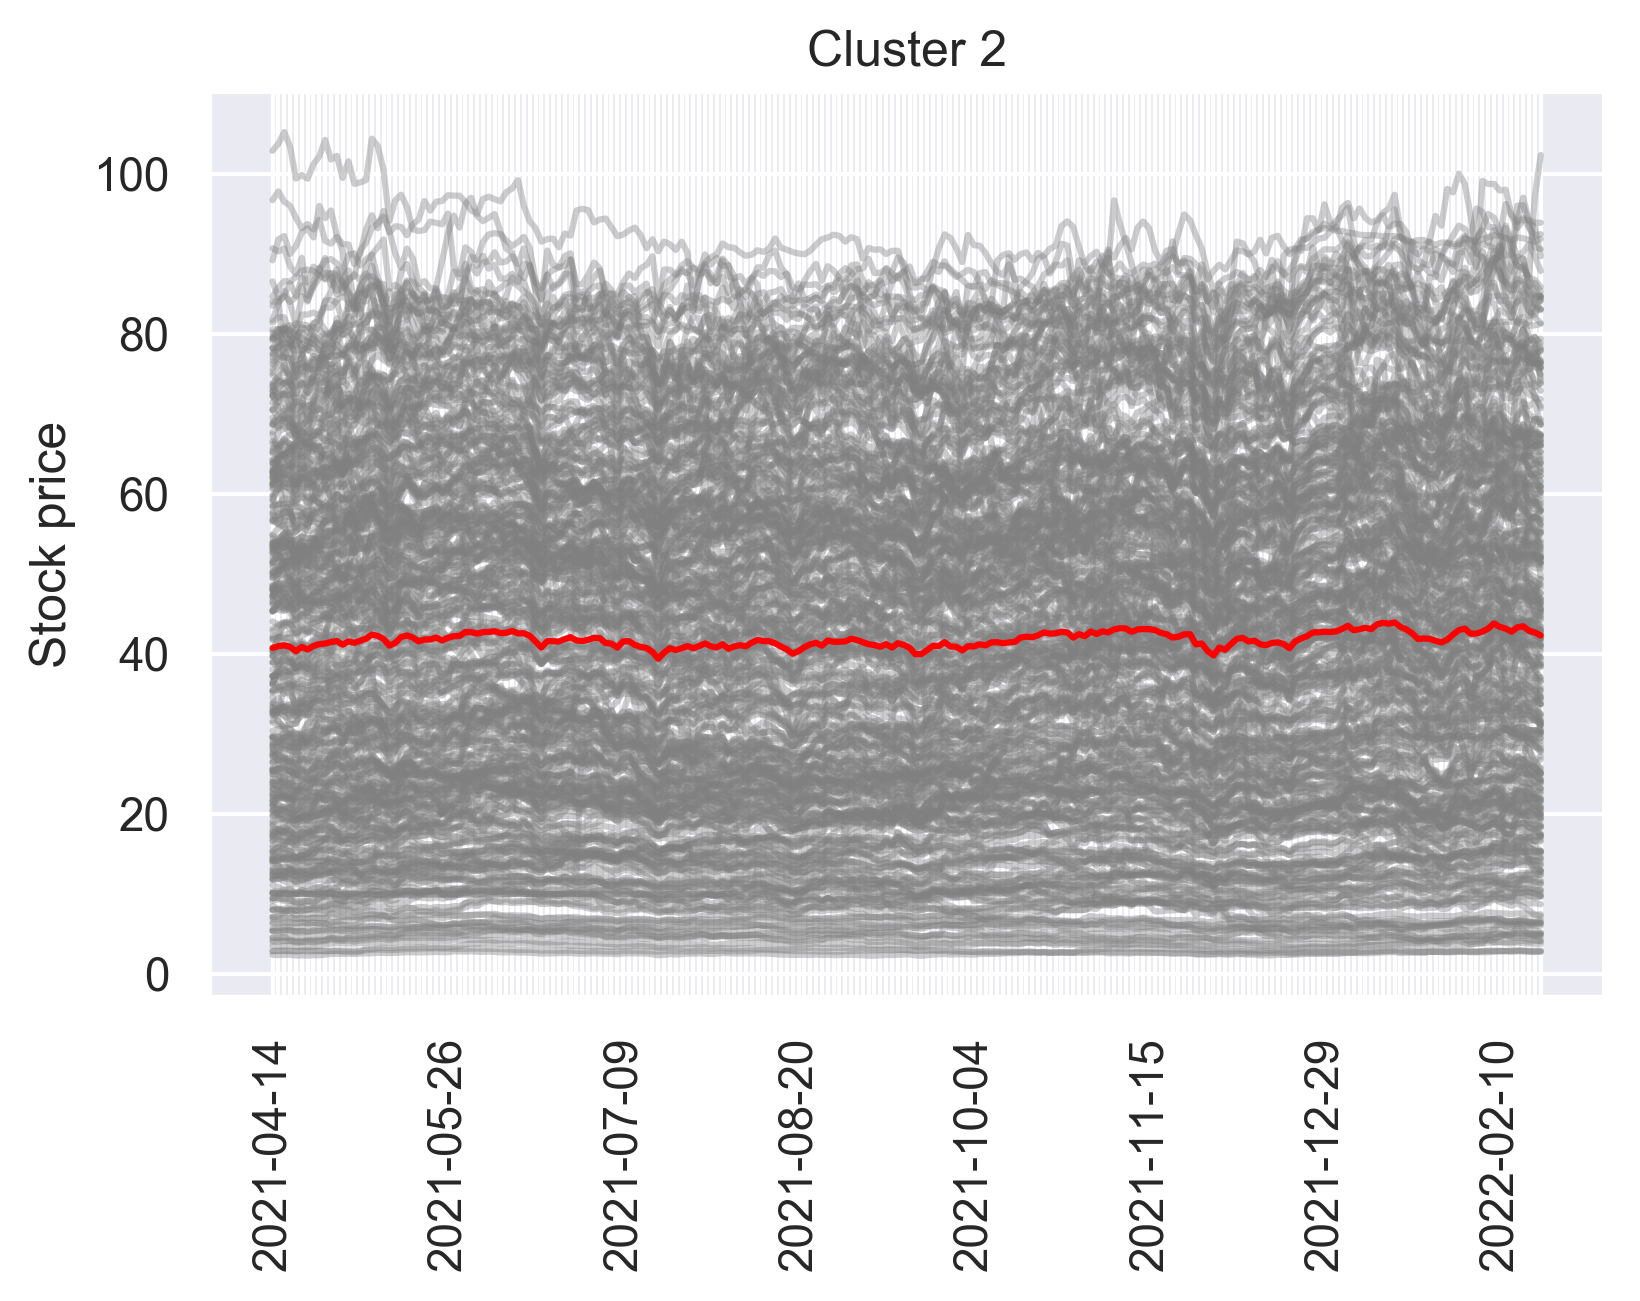

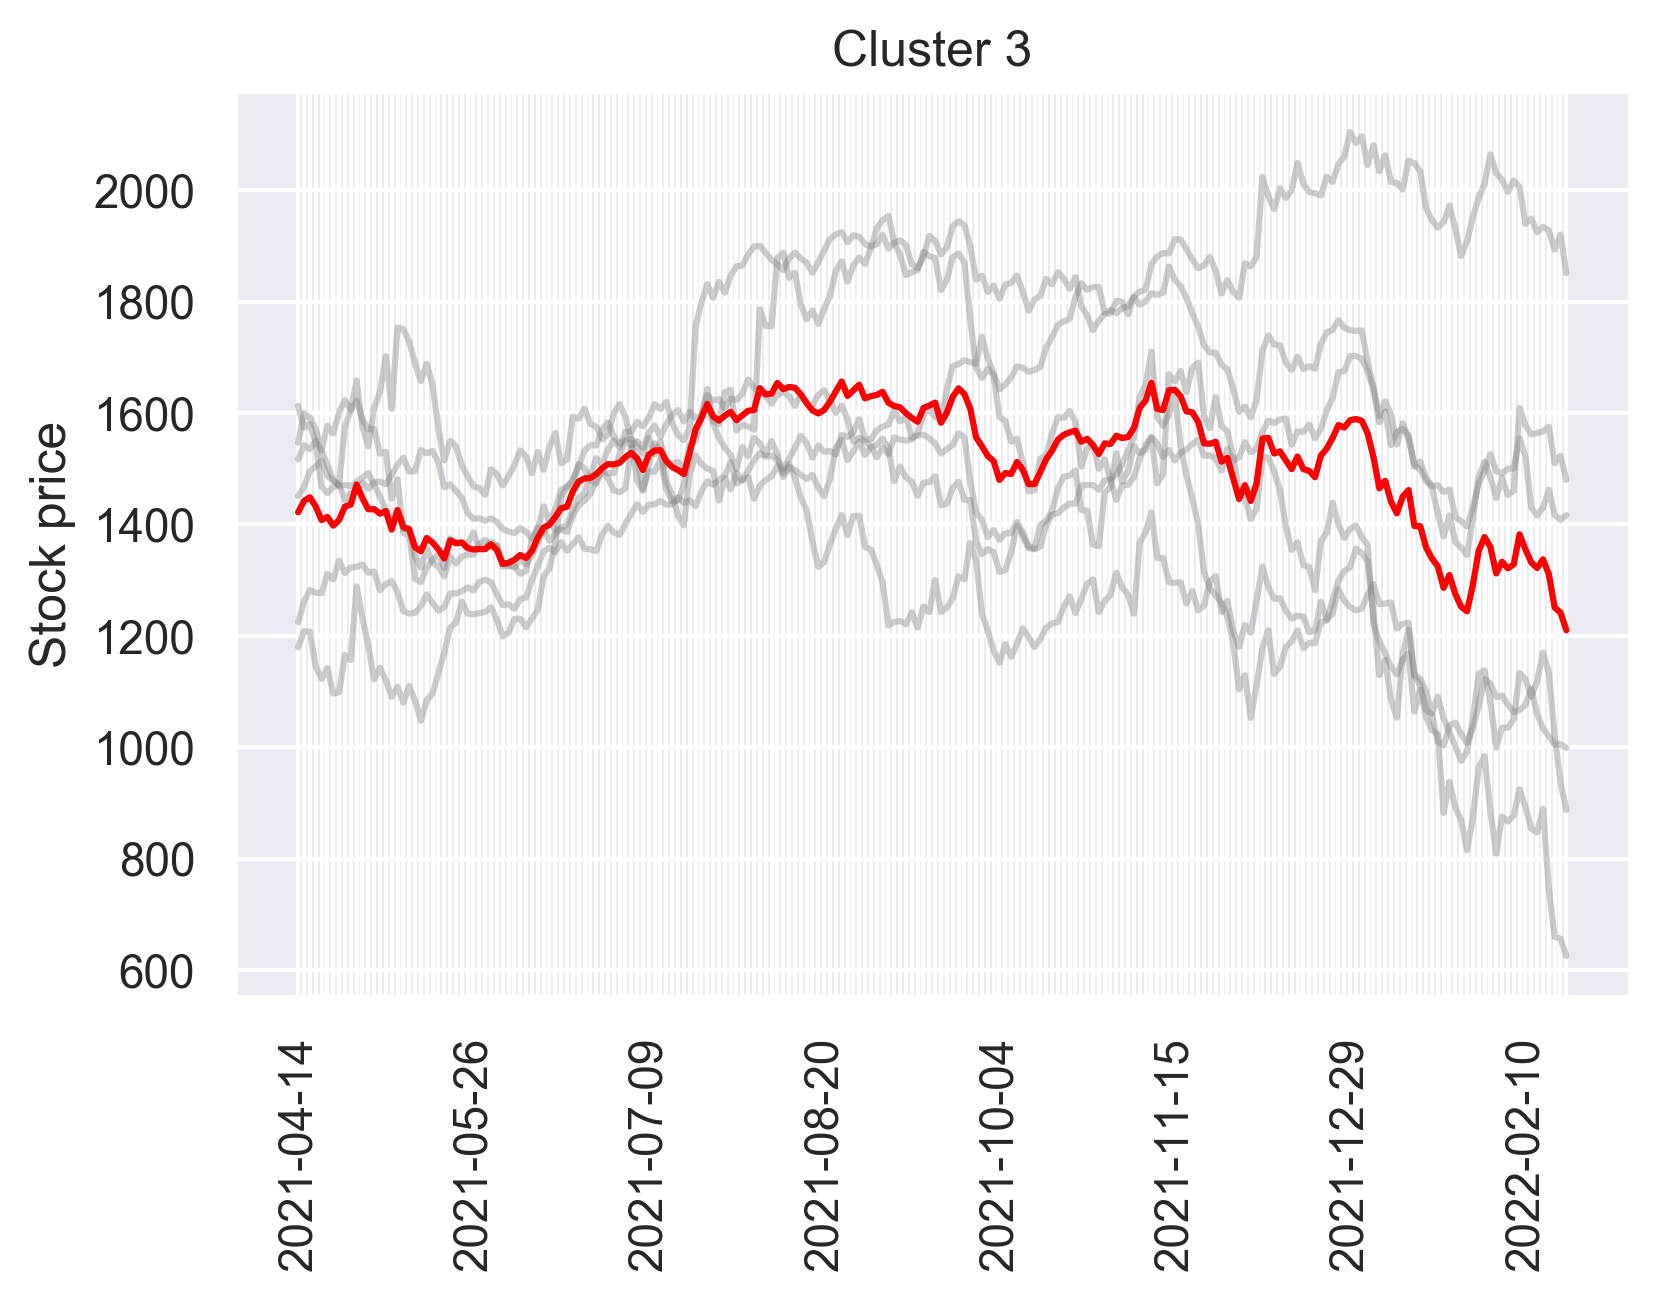

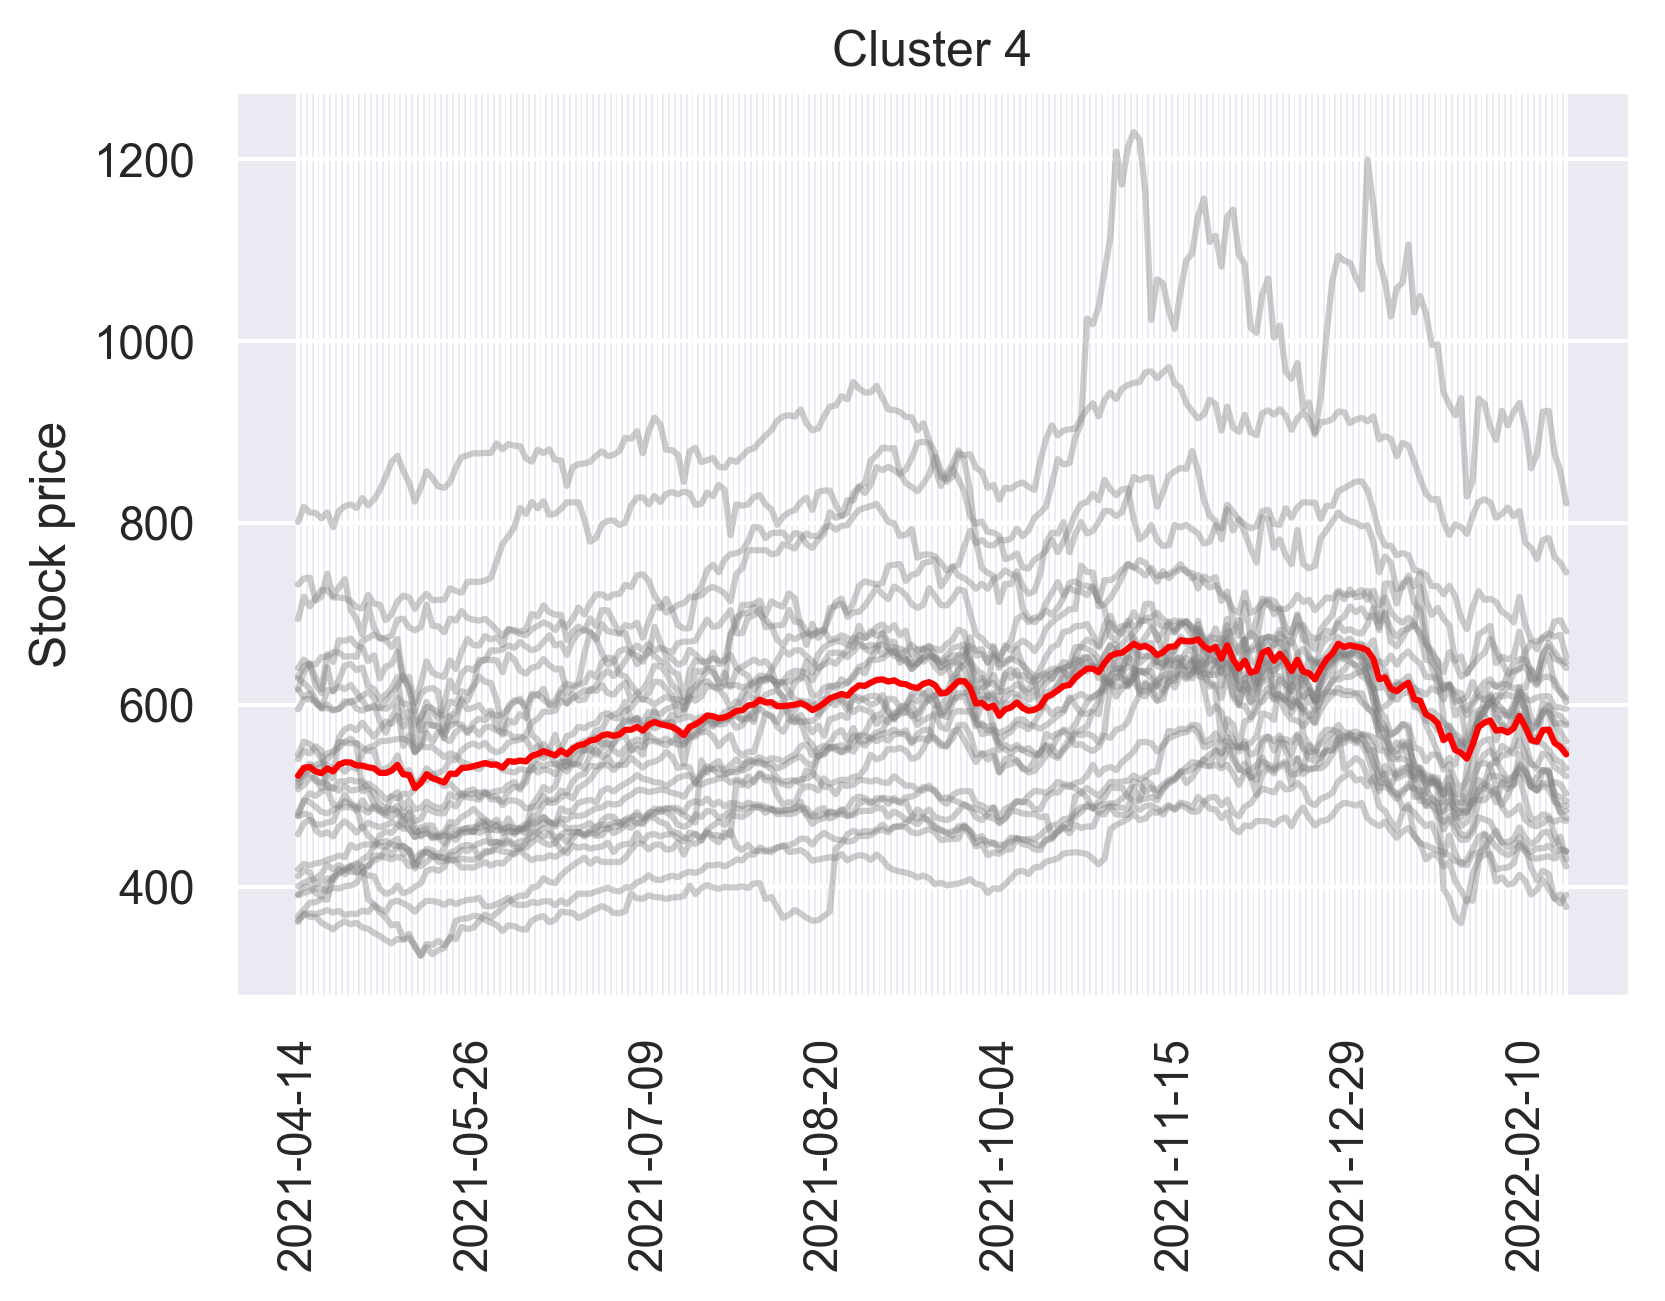

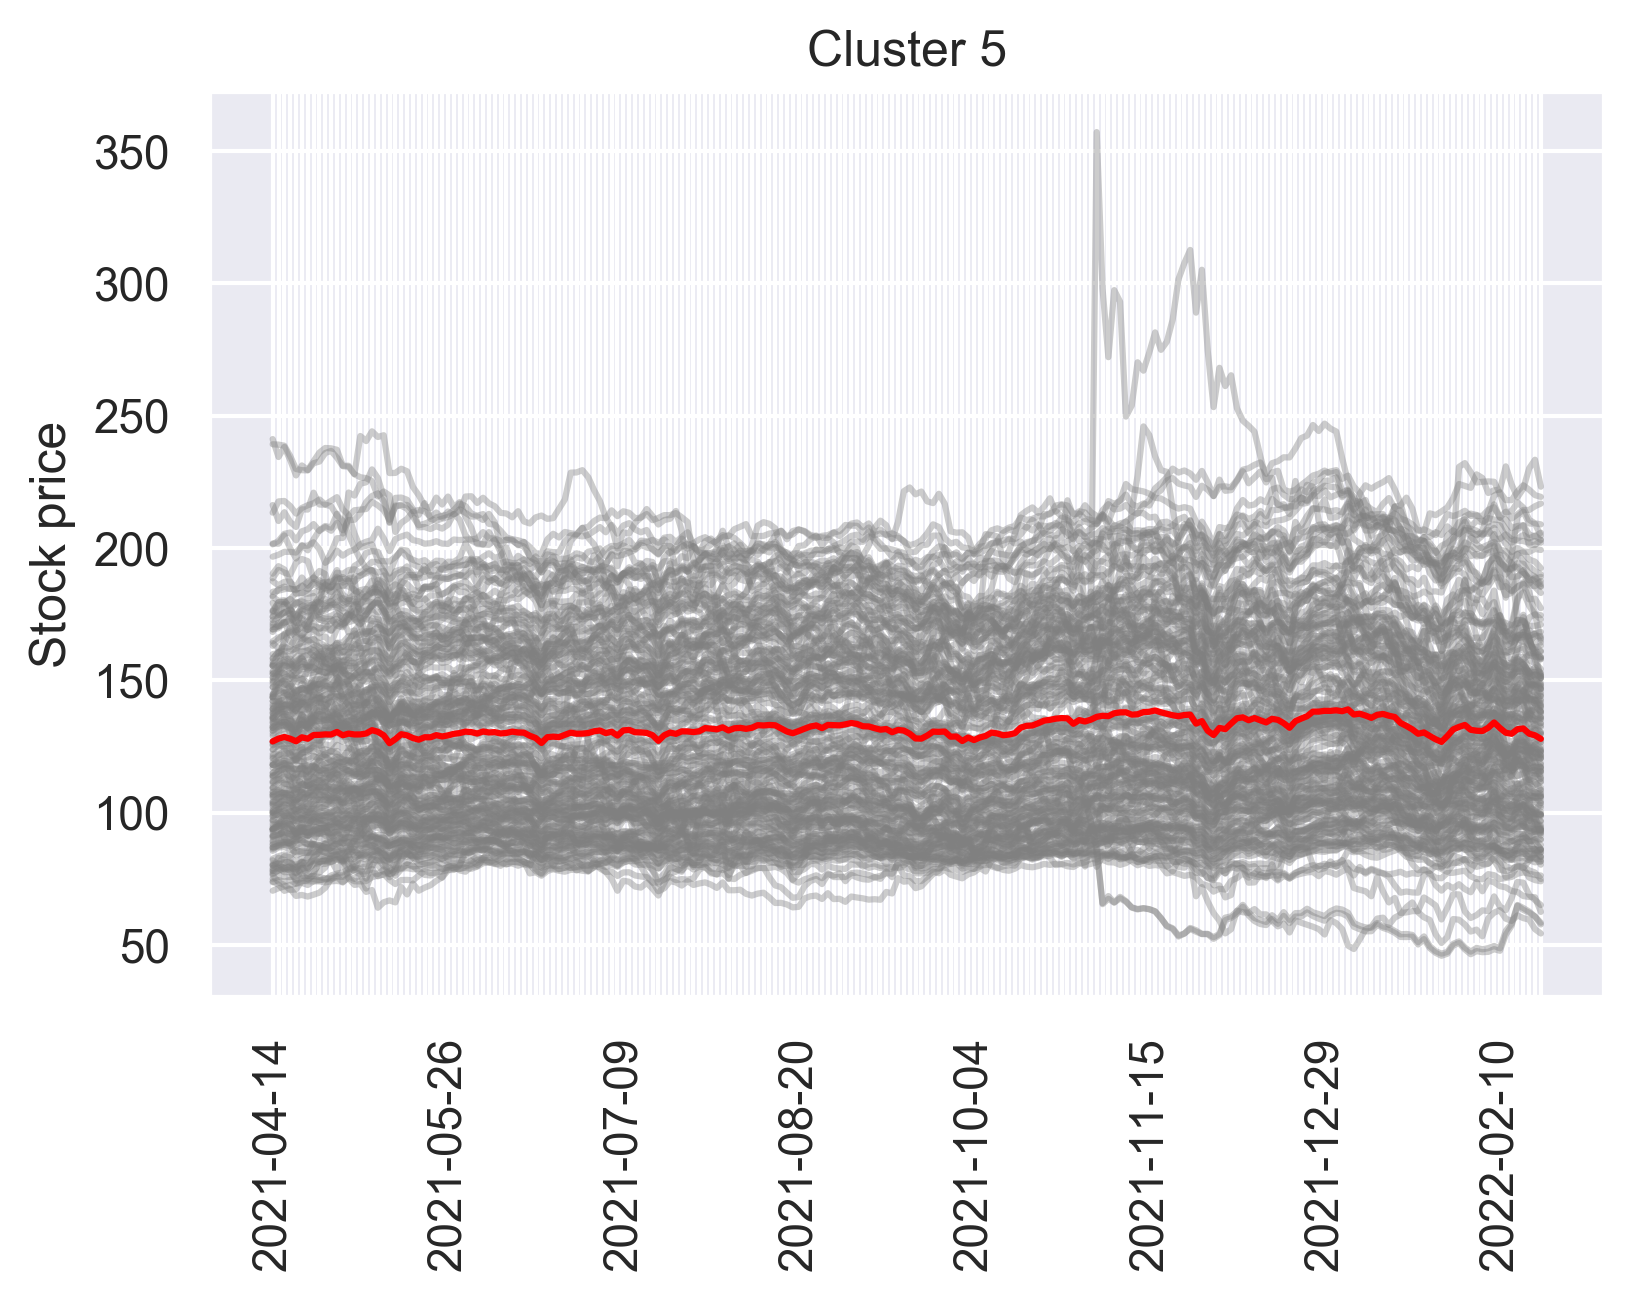

In [126]:
symbols = df_union.columns.to_list()
ticks = df_union.index.to_list()

graphs_dist_by_cluster = []
for index, label in enumerate(set(labels)):
    cluster = []
    fig, ax = plt.subplots()
    for i in range(len(labels)):
        if(labels[i]==label):
            ax.plot(mySeries[i],c="gray",alpha=0.4)
            cluster.append(mySeries[i])

    avg_graph = np.average(np.vstack(cluster),axis=0)
    if len(cluster) > 0:
        ax.plot(avg_graph,c="red")
    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks)
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i % 30 != 0:
            l.set_visible(False)
    plt.xticks(rotation=90)
    ax.set_ylabel("Stock price")
    ax.set_title("Cluster "+str(index))
    plt.show()

    graphs_dist = []
    for i in range(len(labels)):
        if(labels[i]==label):
            graphs_dist.append(np.linalg.norm(avg_graph - mySeries[i]))
    graphs_dist_by_cluster.append(graphs_dist)



* Let's start by creating our data for plotting the result:

In [131]:
namesofMySeries = df_union.columns.to_list()
profit = calc_profit(stocks_time_series).to_list()

fancy_names_for_labels = [f"Cluster {label}" for label in labels]
stocks_clusters = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).set_index("Series")

stocks_clusters["Dist from avg"] = 0
stocks_clusters["Profit"] = profit
for k in range(cluster_count):
    if len(graphs_dist_by_cluster[k]) == 1:
        stocks_clusters["Dist from avg"][stocks_clusters["Cluster"] == f"Cluster {k}"] = 0.0
    else:
        stocks_clusters["Dist from avg"][stocks_clusters["Cluster"] == f"Cluster {k}"] = graphs_dist_by_cluster[k]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Plot the profit graph:

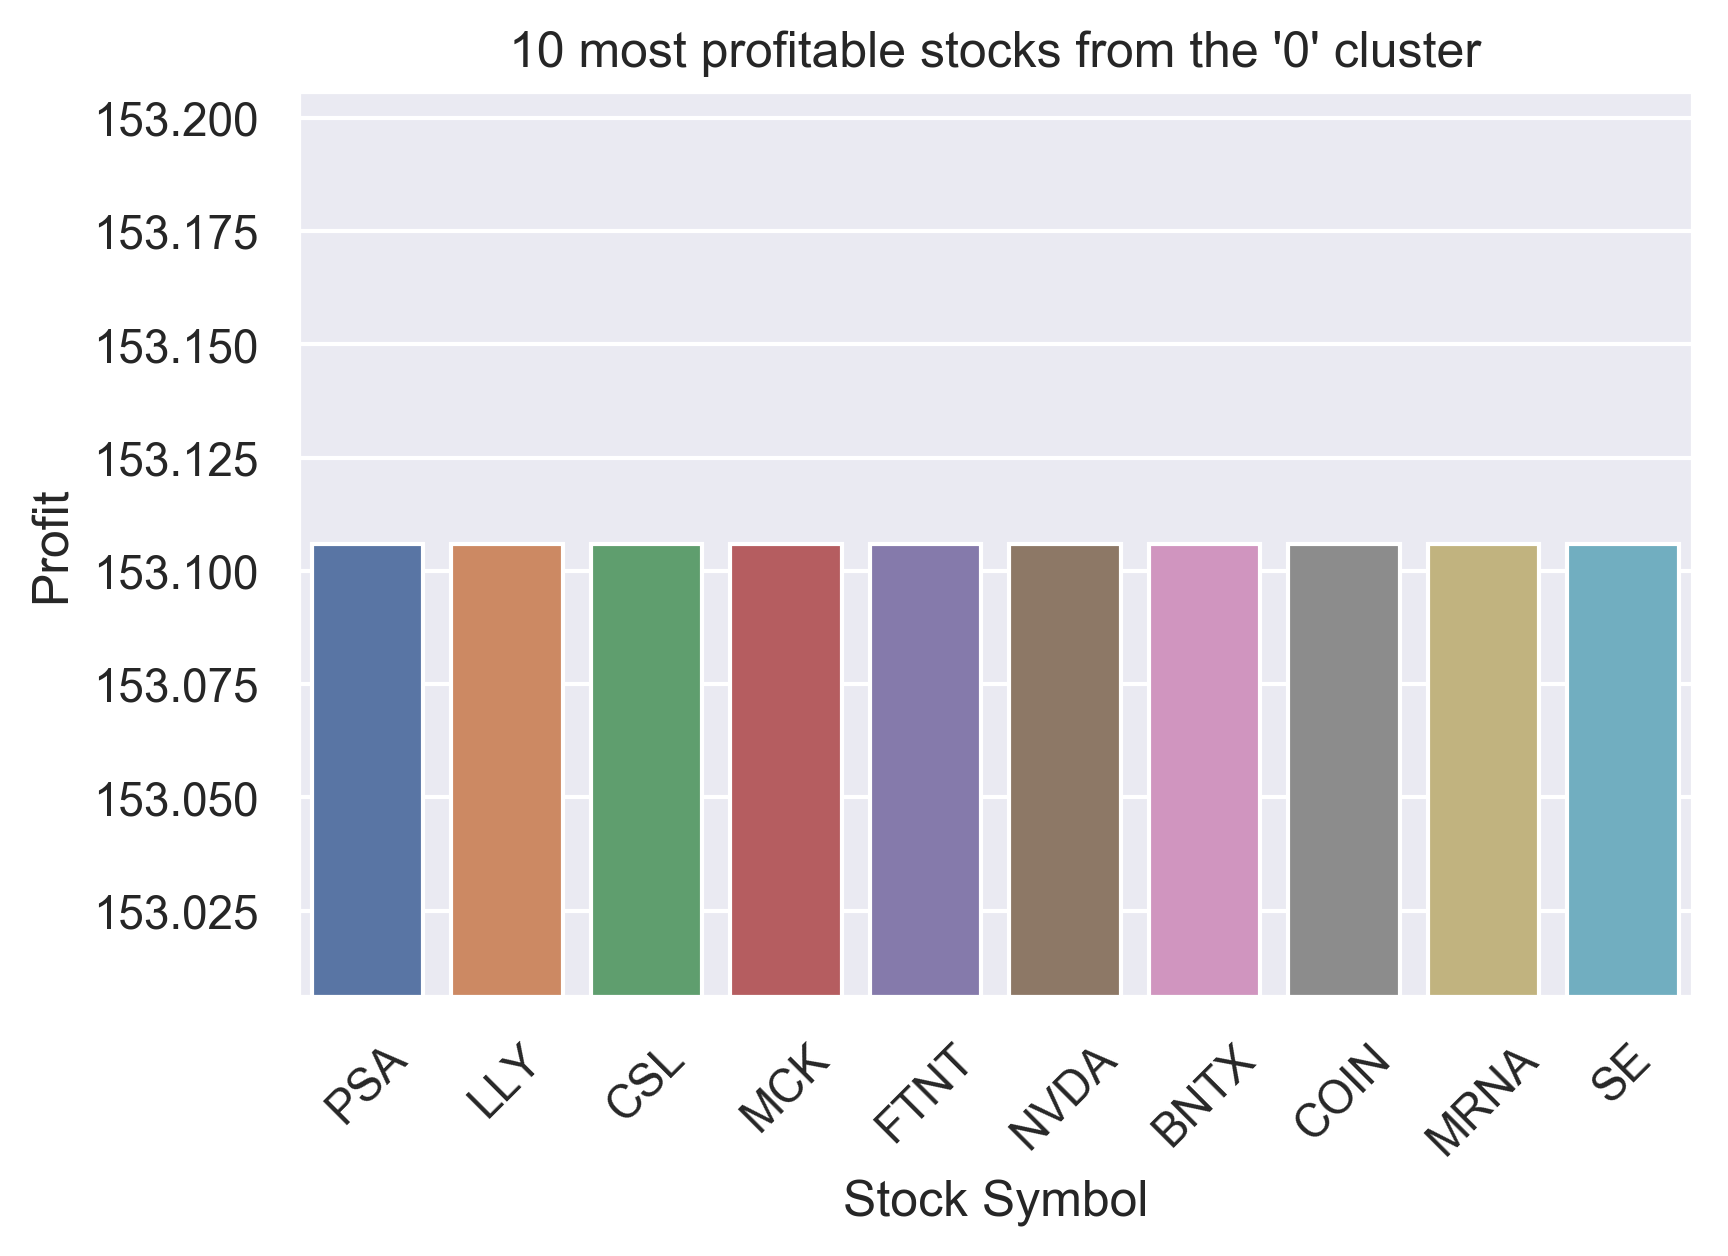

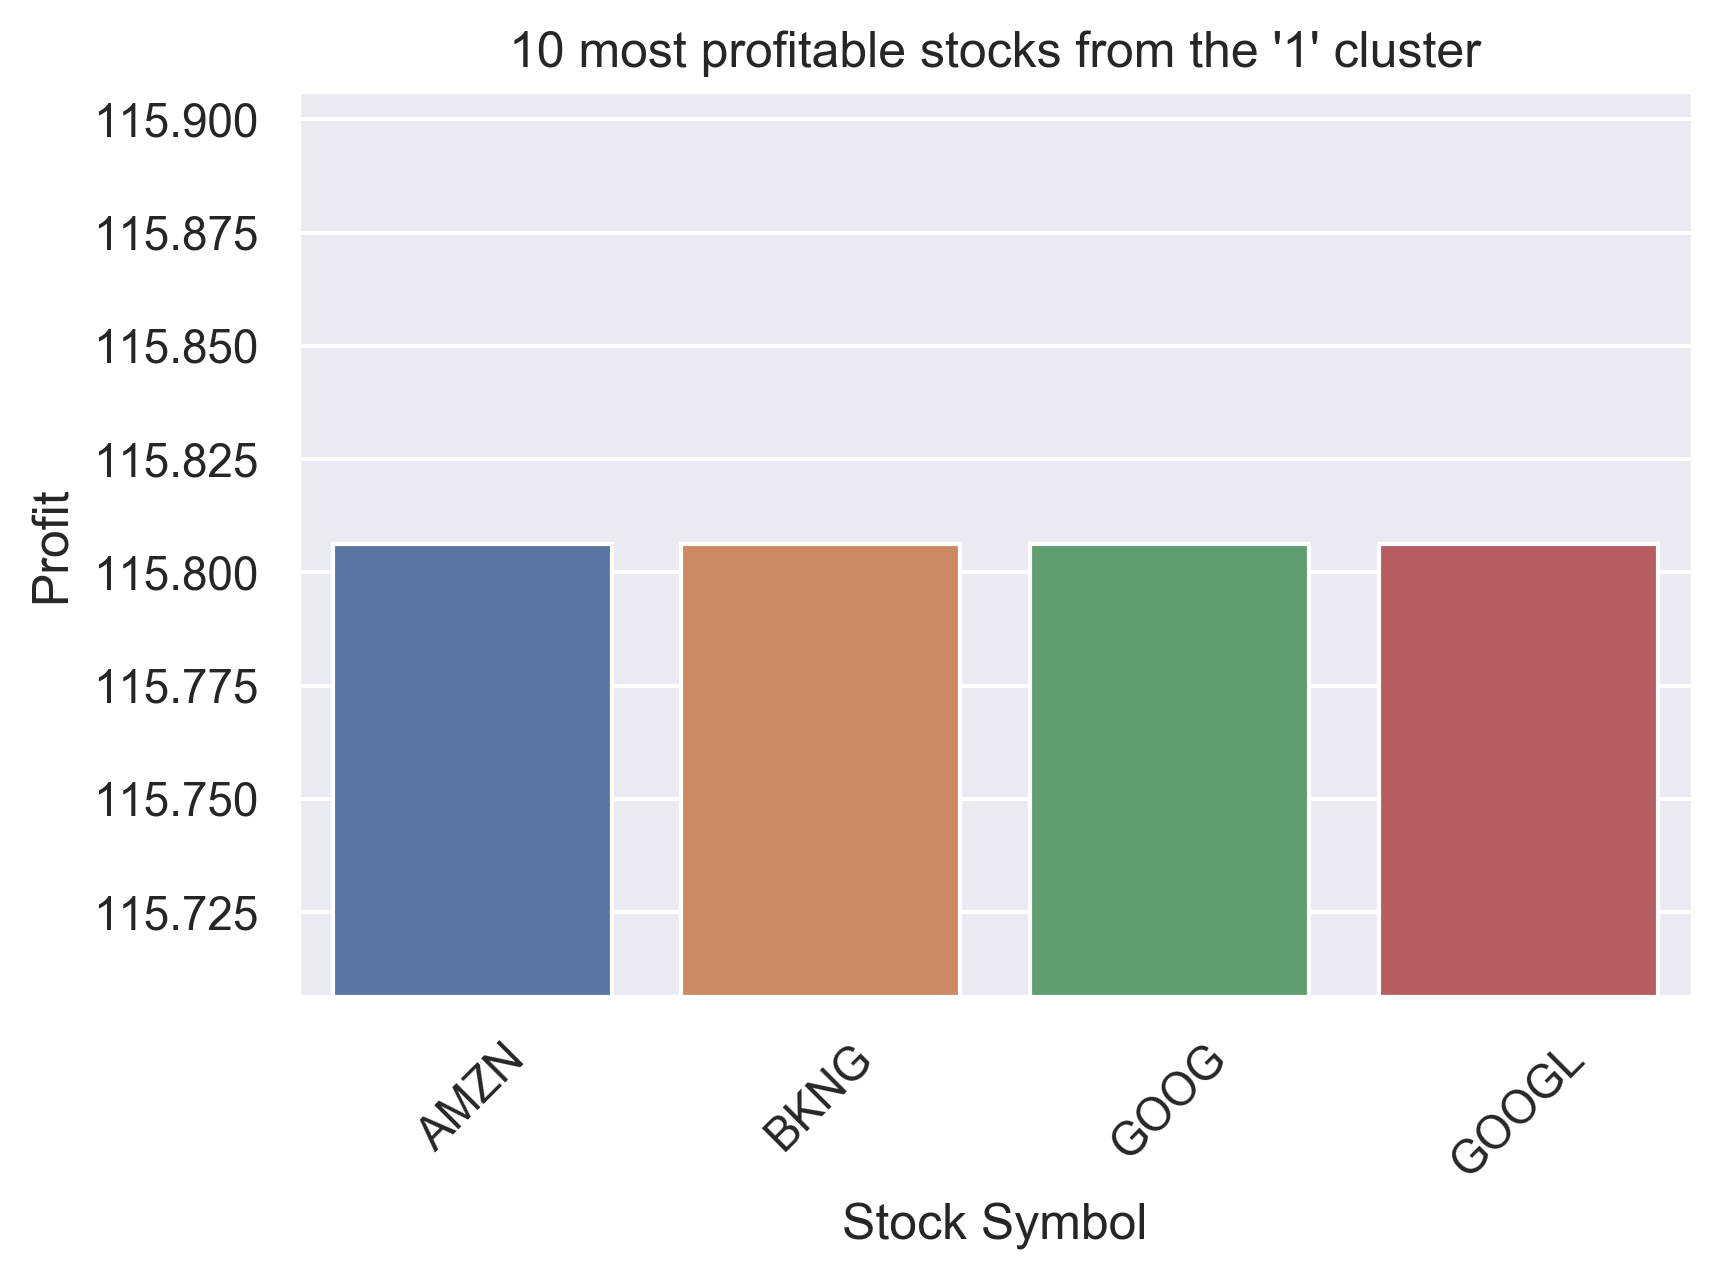

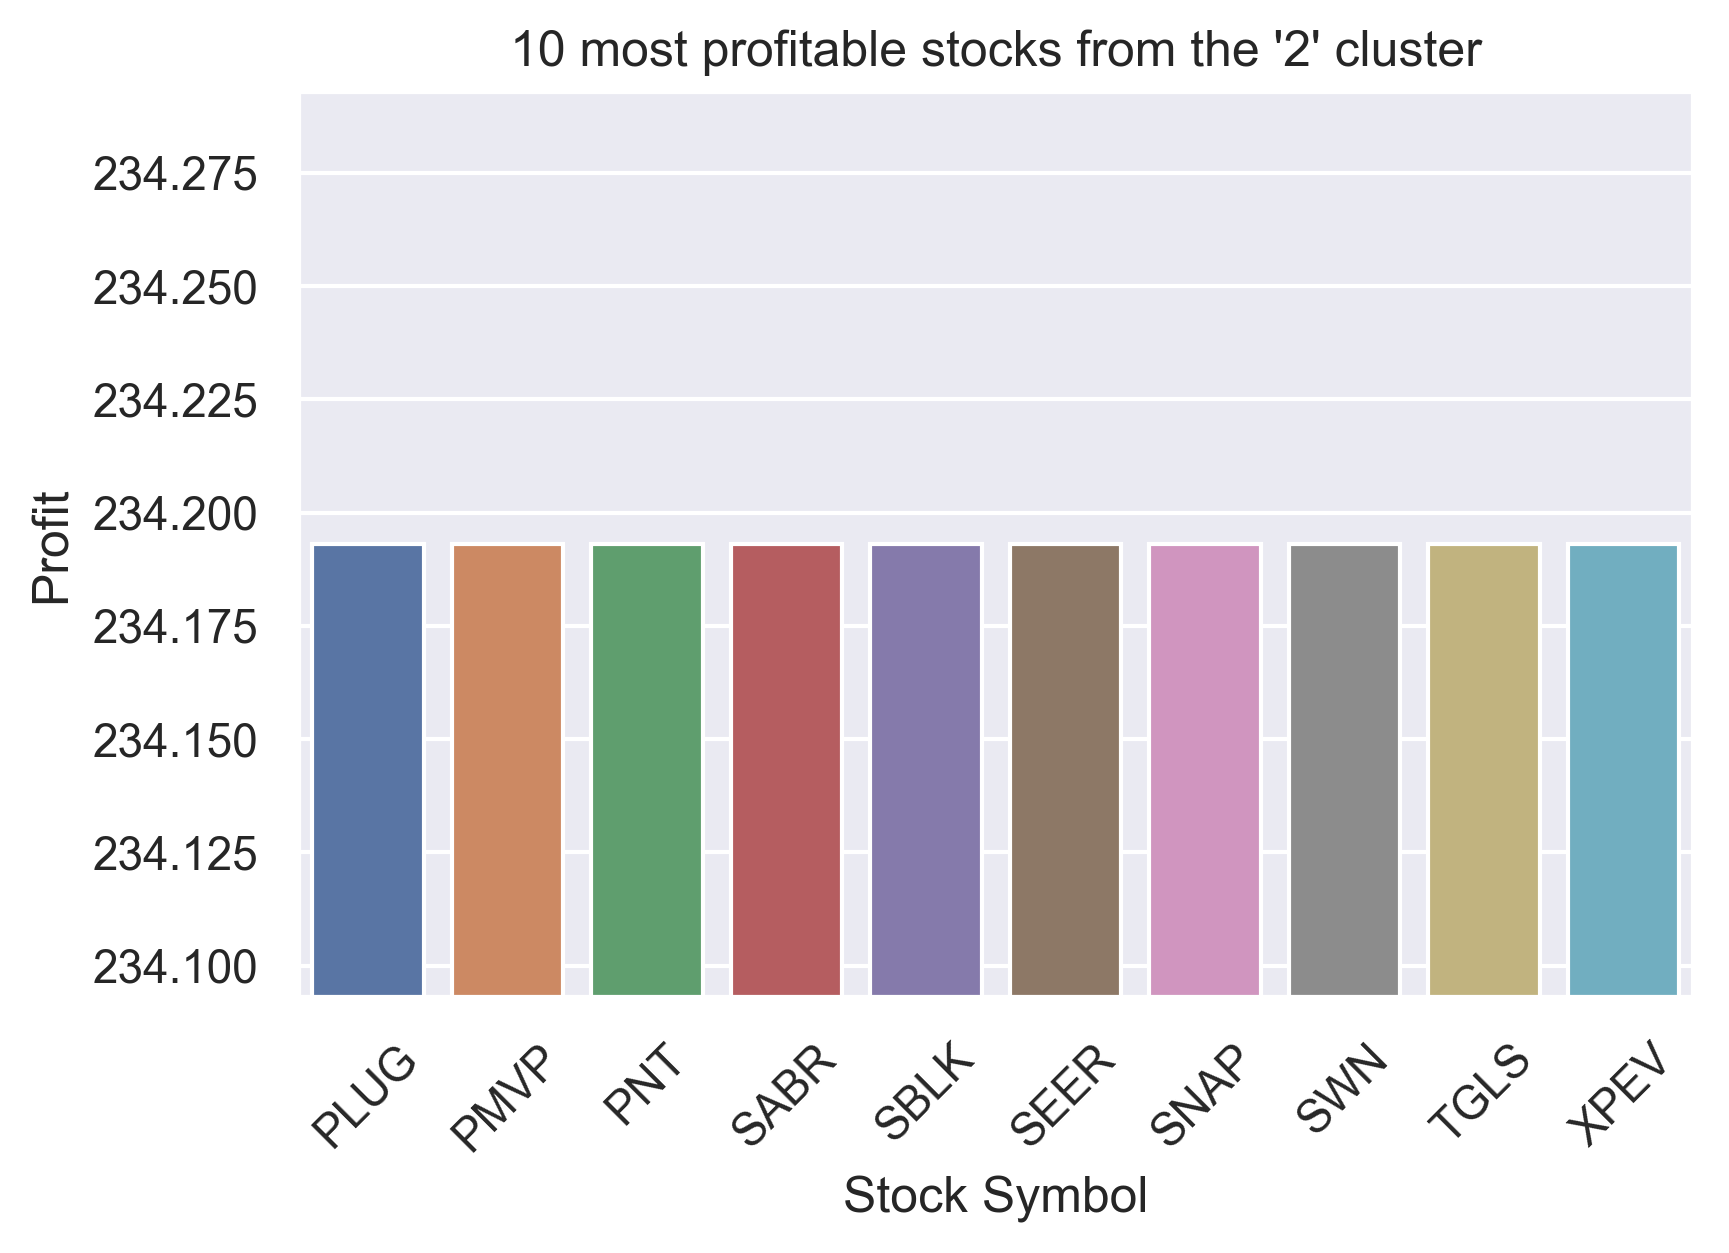

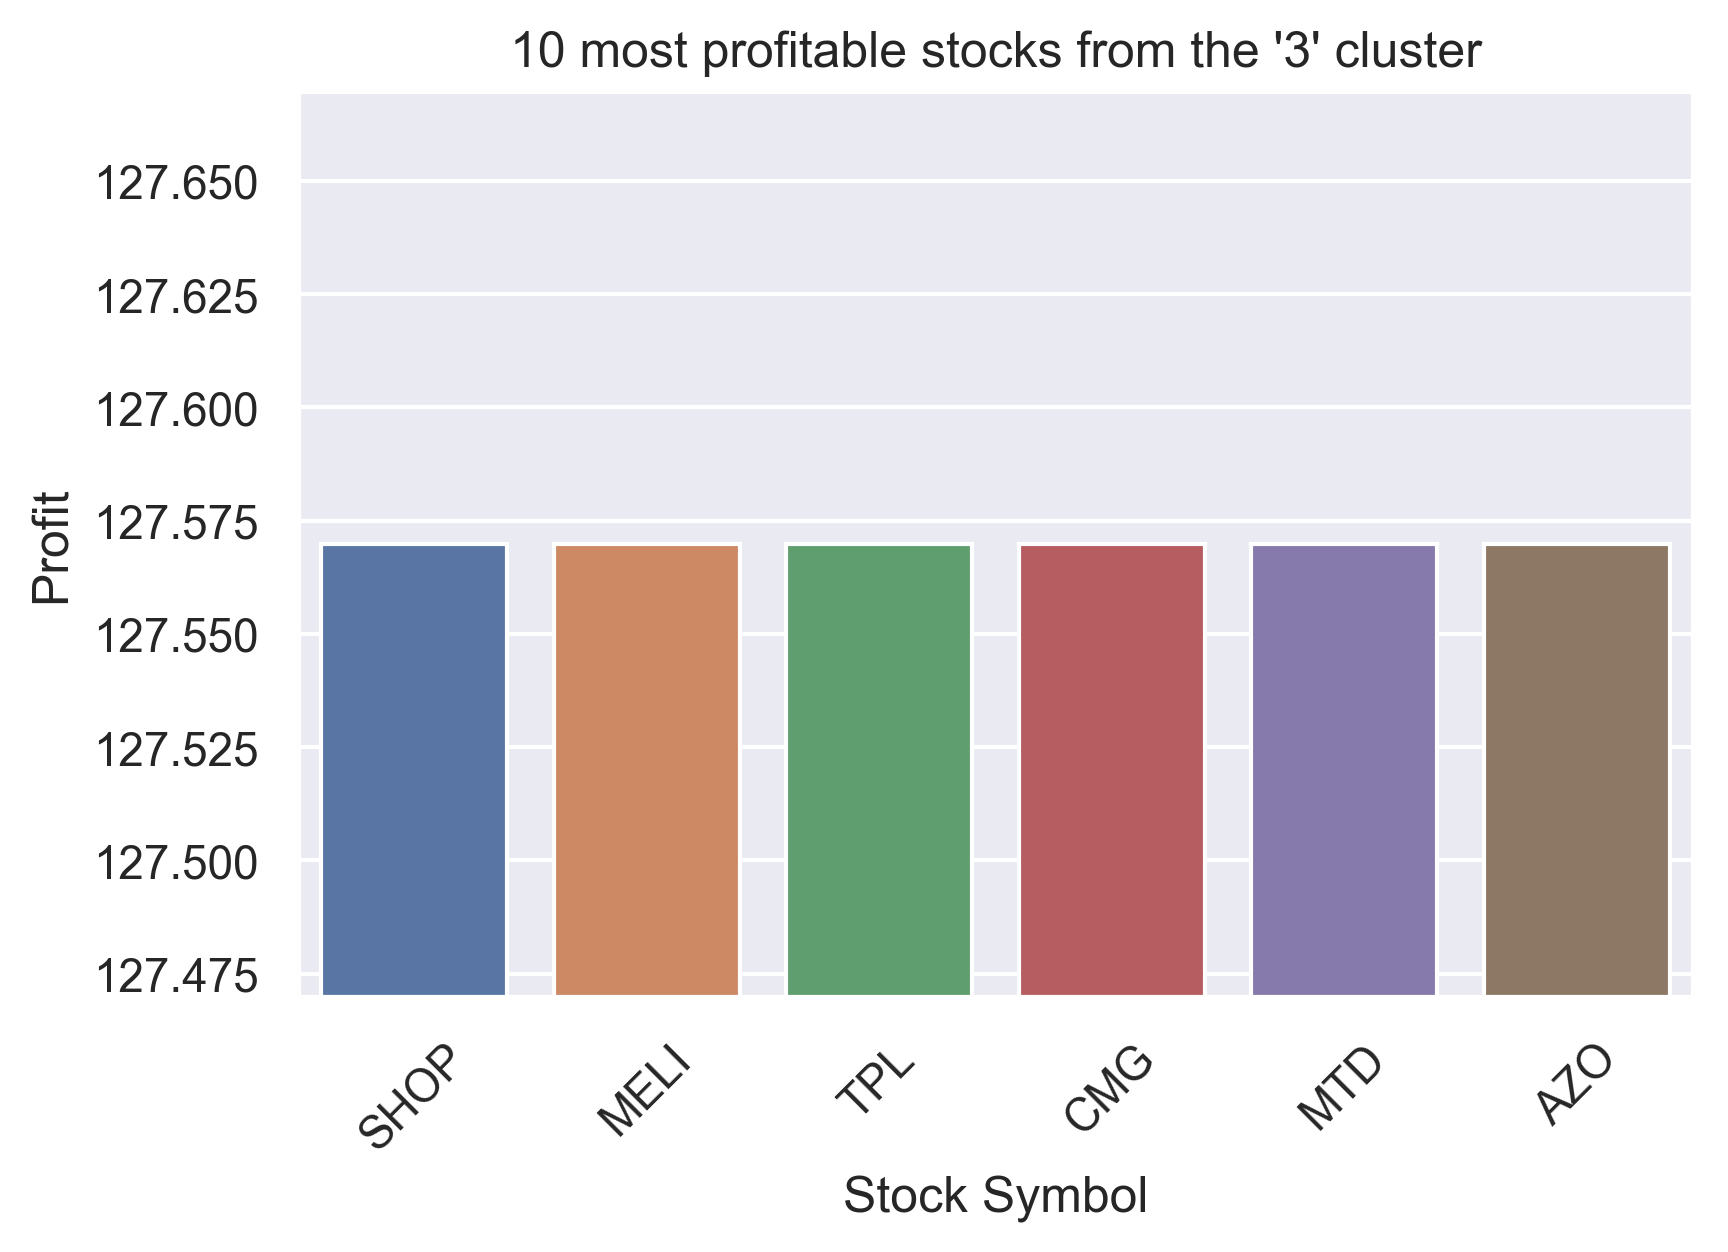

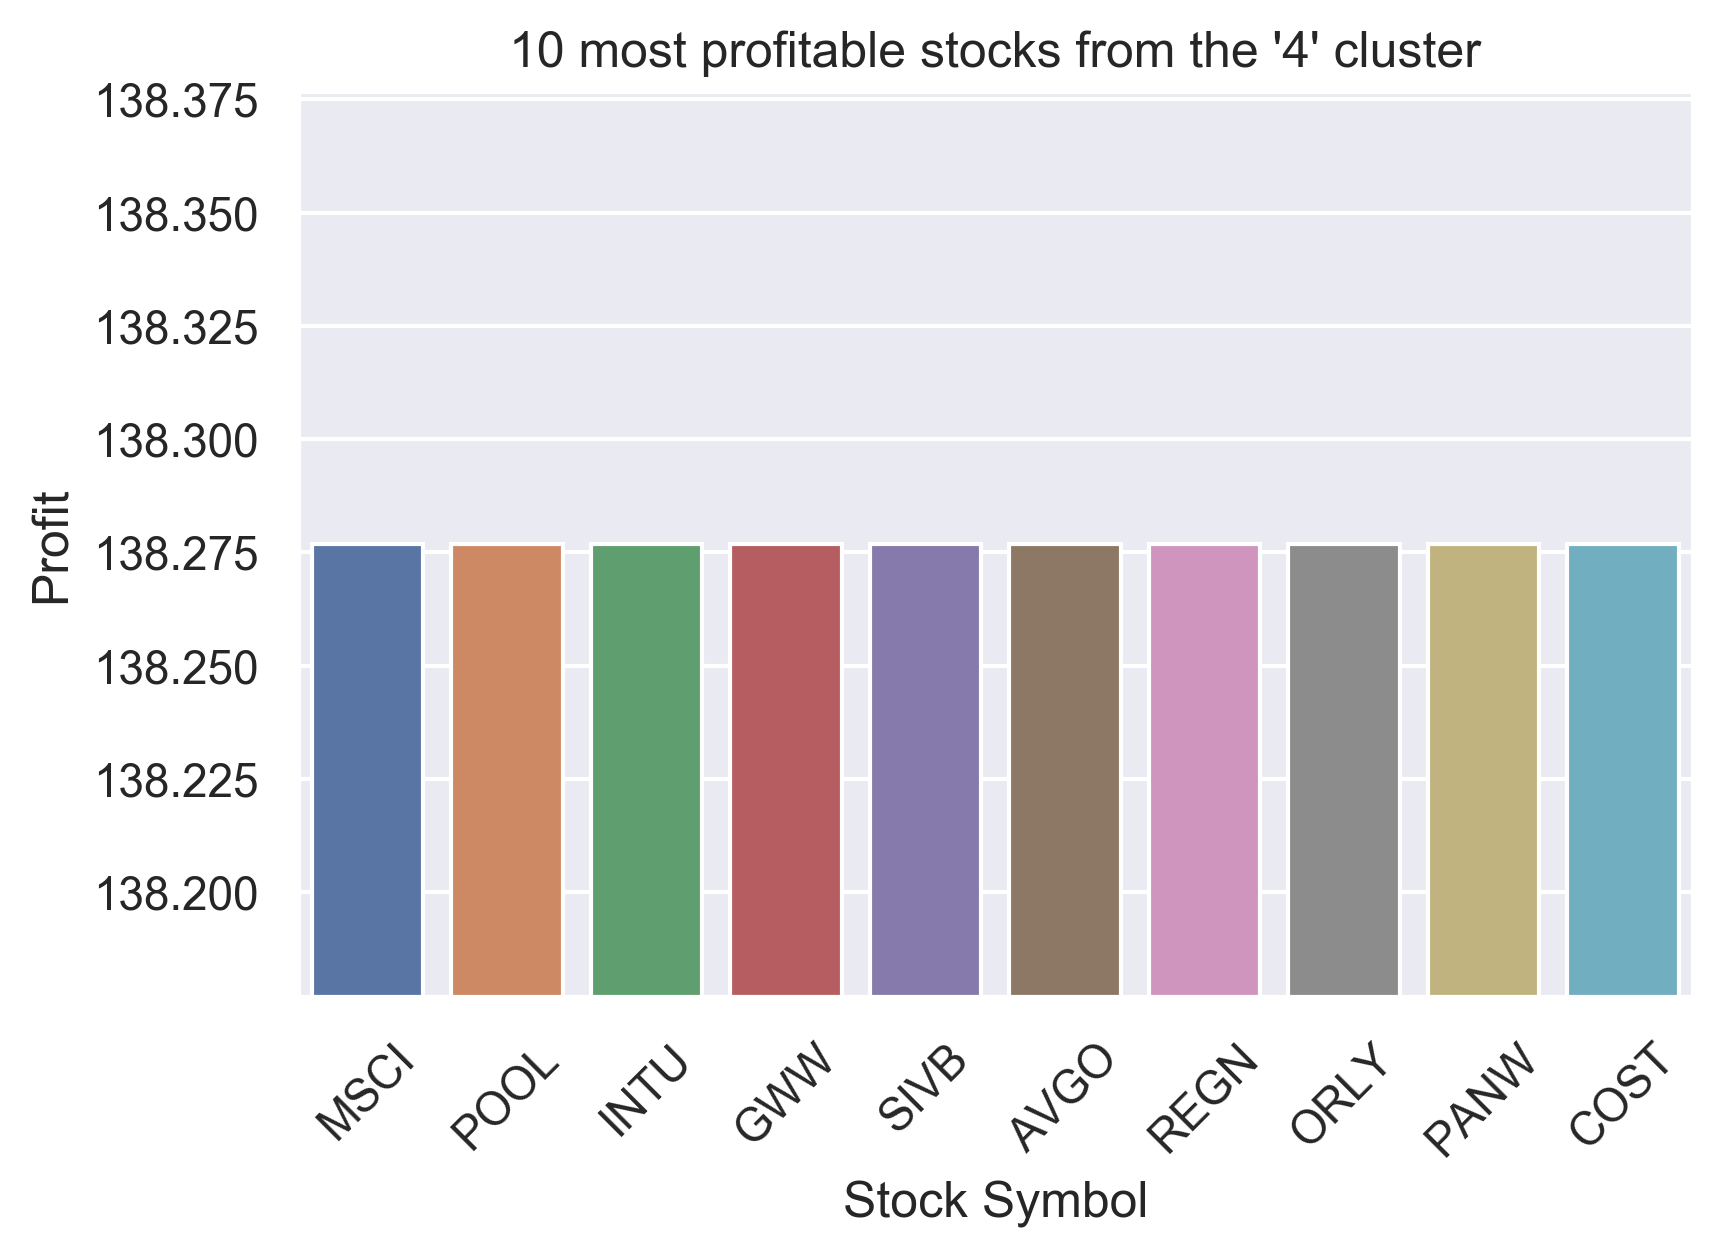

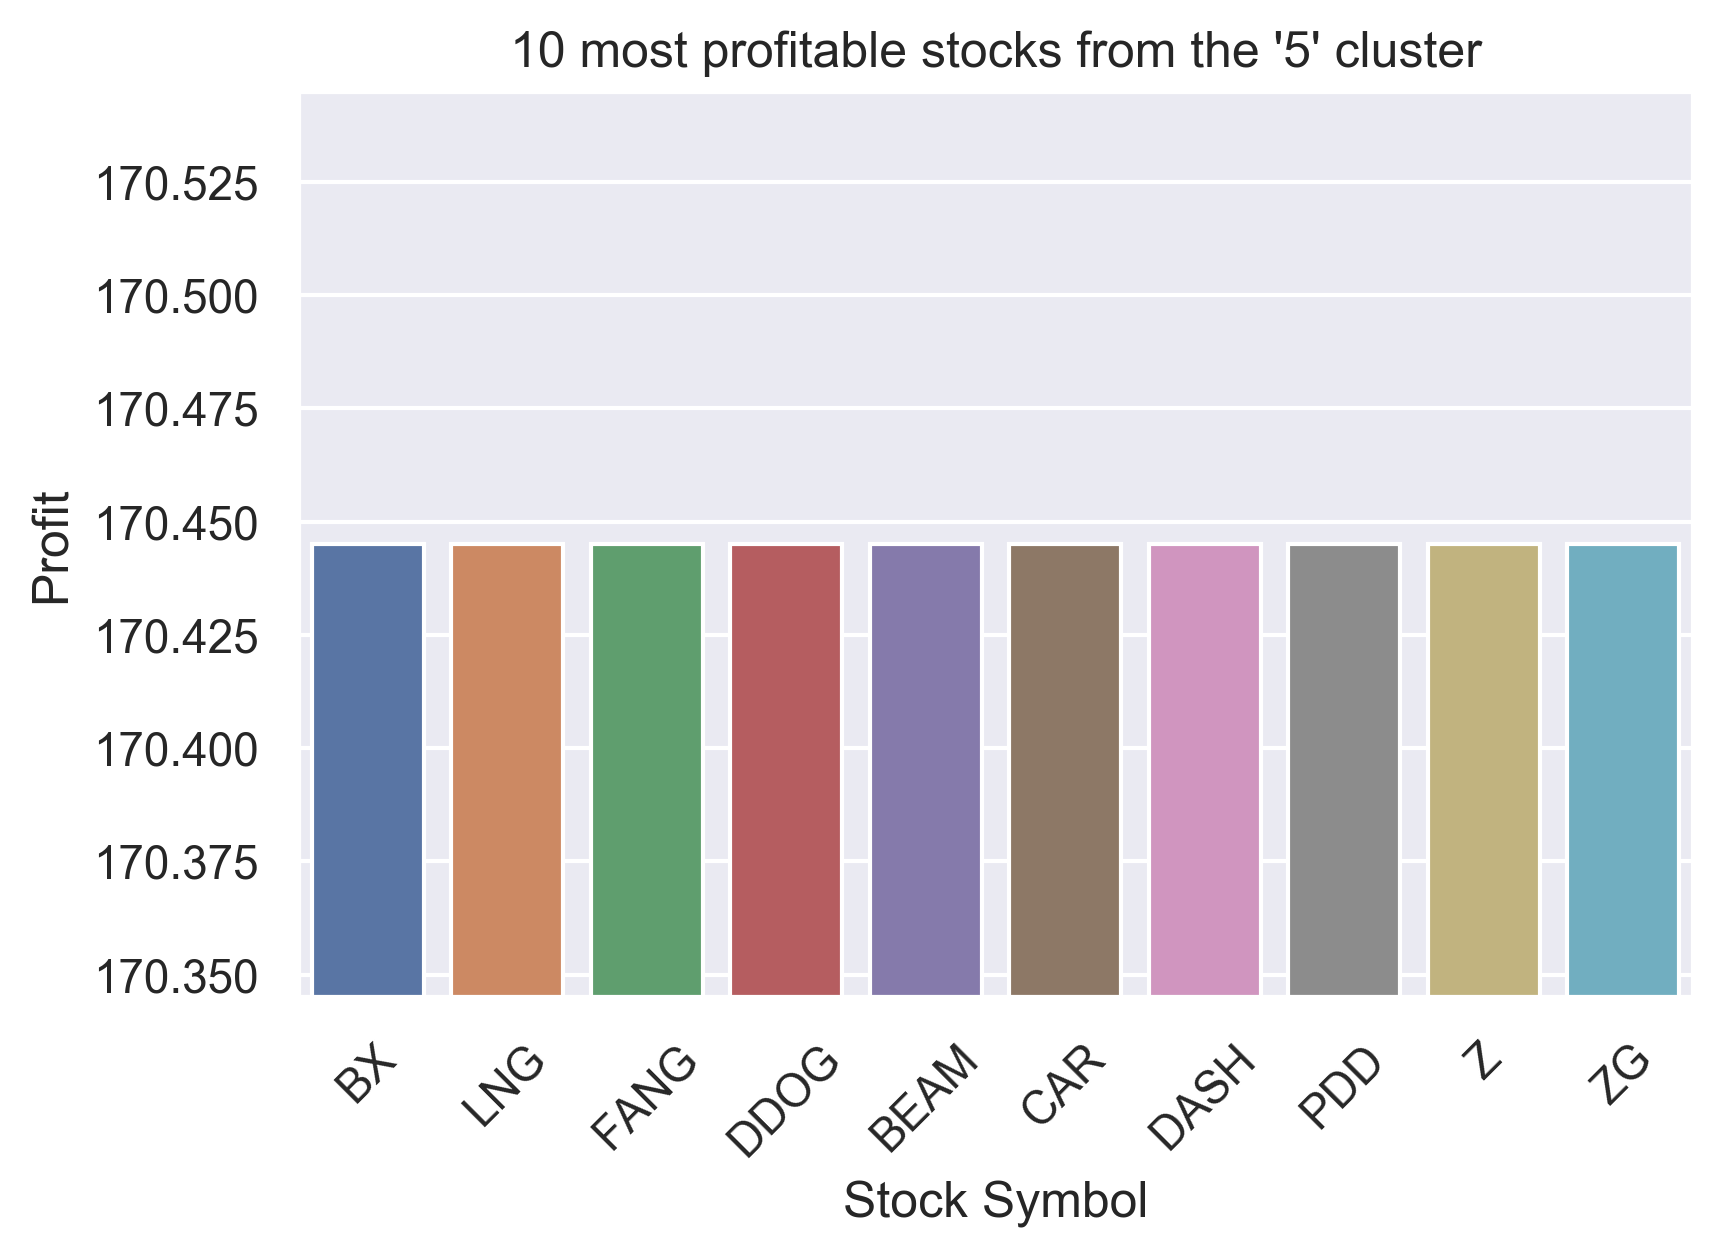

In [164]:
results, results_score = [], []
for i in range(cluster_count):
    df = stocks_clusters.loc[stocks_clusters["Cluster"] == f"Cluster {i}"].drop("Cluster", axis=1).sort_values(by='Profit')

    if np.max(df["Profit"]) != 0.0:
        df["Profit"] = np.max(df["Profit"])
    if np.max(df["Dist from avg"]) != 0.0:
        df["Dist from avg"] /= -np.max(df["Dist from avg"])
    y_bottom = max(0, min(df["Profit"][-10:])-0.1)
    y_upper = max(df["Profit"][-10:]) + 0.1



    sns.barplot(x=df[-10: ].index.to_list(), y='Profit', data=df[-10:])
    plt.xticks(rotation=45)
    plt.ylim(y_bottom, y_upper)
    plt.title(f"10 most profitable stocks from the \'{i}\' cluster")
    plt.xlabel("Stock Symbol")
    plt.ylabel("Profit")
    plt.show()


    max_results = []
    max_results_score = []
    for j, p in enumerate(np.linspace(0.0, 1.0, 10)):
        tmp = ((df["Profit"] * p) + (df["Dist from avg"] * (1 - p))).tolist()
        df[f'{j}'] = tmp
        max_results.append(df.loc[df[f'{j}'] == df[f'{j}'].max()].index[0])
        max_results_score.append(df.loc[df[f'{j}'].idxmax()][f'{j}'])
    results.append(most_frequent(max_results))
    results_score.append(max_results_score[max_results.index(results[-1])])


### Print results:

In [166]:
print_results(results, results_score, cluster_count)

We recommend to invest in:
AMT
'AMT' stock from the Finance sector, with score of -0.113, from the "0" cluster
GOOG
'GOOG' stock from the Technology sector, with score of -0.189, from the "1" cluster
SLGN
'SLGN' stock from the Consumer Durables sector, with score of -0.031, from the "2" cluster
MTD
'MTD' stock from the Health Care sector, with score of -0.333, from the "3" cluster
NOW
'NOW' stock from the Technology sector, with score of -0.119, from the "4" cluster
AME
'AME' stock from the Consumer Durables sector, with score of -0.069, from the "5" cluster
